## Figure 1: Comparing fitted model to TNG100 (and Neijssel et al 2019)

In [1]:
#imports from FitComparison_3panelPlot
import os
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u
from astropy import constants as const

from scipy import interpolate
from scipy.optimize import minimize
from scipy.optimize import curve_fit

#from astropy.cosmology import WMAP9, z_at_value
from astropy.cosmology import Planck15  as cosmo# Planck 2018
from astropy.cosmology import z_at_value
from astropy.table import Table

from matplotlib import rc
import matplotlib
from matplotlib import ticker, cm
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap

############################
# Custom scripts
import get_ZdepSFRD as Z_SFRD

In [2]:
newcosmo =cosmo.clone(name='Planck15_modified', H0 = 67.8, Om0=0.308)

In [3]:
#define chirp mass function
def Mchirp(m1, m2):
    chirp_mass = np.divide(np.power(np.multiply(m1, m2), 3./5.), np.power(np.add(m1, m2), 1./5.))
    return chirp_mass   

In [4]:
#set values
Zsun = 0.014 #solar metallicity
mu_0      =0.025
mu_z      =-0.049
omega_0   =1.129
omega_z   =0.048
alpha  =-1.778

sf_a     =0.017
sf_b     =1.481
sf_c     =4.452
sf_d     =5.913

TNGlocation = '/home/sashalvna/research/Fit_SFRD_TNG100/data'

In [5]:
path = TNGlocation+'/SFRMetallicityFromGasTNG100.hdf5'
TNGmetallicities = h5.File(path, 'r')
list(TNGmetallicities.keys())

['Lookbacktimes', 'MetalBins', 'Redshifts', 'Sfr']

In [6]:
#read out "observed" values from TNG, and convert units of SFR
TNGlookbacktimes = TNGmetallicities['Lookbacktimes'][:]
TNGmetalbins = TNGmetallicities['MetalBins'][:]
TNGredshifts = TNGmetallicities['Redshifts'][:]
TNGsfr = TNGmetallicities['Sfr'][:]

# Convert SFR from sfr/box to sfr Mpc-3
littleh = 0.6774
Rbox    = 75/littleh
Obs_cosmic_SFR = TNGsfr / Rbox**3 *u.Mpc**-3
Obs_cosmic_SFR = Obs_cosmic_SFR.value
Obs_cosmic_SFR = Obs_cosmic_SFR.T

In [7]:
#Get centers of each metallicity bin, convert metallicity bins to log10 scale and find the Z steps betwen the bins
Obs_center_Zbin = (TNGmetalbins[:-1] + TNGmetalbins[1:])/2.
log_obs_metallicities = np.log10(TNGmetalbins)
step_obs_logZ = np.diff(log_obs_metallicities)[0]

In [8]:
Obs_redshifts = [z_at_value(cosmo.lookback_time,t*u.Gyr,method='Bounded') for t in TNGlookbacktimes[:-1]] 
Obs_redshifts.insert(len(Obs_redshifts),0) # put redshift zero at the end 
Obs_redshifts = np.array(Obs_redshifts)
Obs_Lookbacktimes = TNGlookbacktimes

Text(0.5, 0, 'Read in redshift')

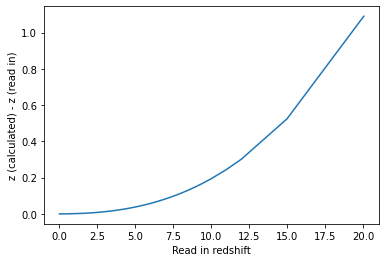

In [9]:
#Redshift calculated from lookback time and redshifts from file not the same? why?
plt.plot(TNGredshifts, (Obs_redshifts-TNGredshifts))
plt.ylabel("z (calculated) - z (read in)")
plt.xlabel("Read in redshift")

In [10]:
print(TNGredshifts)

[2.00464910e+01 1.49891732e+01 1.19802133e+01 1.09756433e+01
 9.99659047e+00 9.38877127e+00 9.00233985e+00 8.44947629e+00
 8.01217295e+00 7.59510715e+00 7.23627607e+00 7.00541705e+00
 6.49159775e+00 6.01075740e+00 5.84661375e+00 5.52976581e+00
 5.22758097e+00 4.99593347e+00 4.66451770e+00 4.42803374e+00
 4.17683491e+00 4.00794511e+00 3.70877426e+00 3.49086137e+00
 3.28303306e+00 3.00813107e+00 2.89578501e+00 2.73314262e+00
 2.57729027e+00 2.44422570e+00 2.31611074e+00 2.20792547e+00
 2.10326965e+00 2.00202814e+00 1.90408954e+00 1.82268925e+00
 1.74357057e+00 1.66666956e+00 1.60423452e+00 1.53123903e+00
 1.49551217e+00 1.41409822e+00 1.35757667e+00 1.30237846e+00
 1.24847261e+00 1.20625808e+00 1.15460271e+00 1.11415056e+00
 1.07445789e+00 1.03551045e+00 9.97294226e-01 9.50531352e-01
 9.23000816e-01 8.86896938e-01 8.51470901e-01 8.16709979e-01
 7.91068249e-01 7.57441373e-01 7.32636182e-01 7.00106354e-01
 6.76110411e-01 6.44641841e-01 6.21428745e-01 5.98543288e-01
 5.75980845e-01 5.463921

In [11]:
print(Obs_redshifts)

[2.11366939e+01 1.55134898e+01 1.22817885e+01 1.12191886e+01
 1.01907724e+01 9.55570557e+00 9.15325152e+00 8.57916554e+00
 8.12645197e+00 7.69578567e+00 7.32608555e+00 7.08863080e+00
 6.56121667e+00 6.06896650e+00 5.90120916e+00 5.57777951e+00
 5.26978948e+00 5.03399554e+00 4.69709300e+00 4.45700578e+00
 4.20225590e+00 4.03113469e+00 3.72831070e+00 3.50797133e+00
 3.29800718e+00 3.02053929e+00 2.90722718e+00 2.74326885e+00
 2.58624513e+00 2.45224819e+00 2.32329305e+00 2.21444131e+00
 2.10917744e+00 2.00738130e+00 1.90893706e+00 1.82713910e+00
 1.74765323e+00 1.67041322e+00 1.60771574e+00 1.53442766e+00
 1.49856310e+00 1.41684870e+00 1.36012931e+00 1.30474621e+00
 1.25066763e+00 1.20832312e+00 1.15651495e+00 1.11594786e+00
 1.07614637e+00 1.03709595e+00 9.98782249e-01 9.51904841e-01
 9.24309290e-01 8.88122818e-01 8.52618630e-01 8.17783775e-01
 7.92089215e-01 7.58395235e-01 7.33542117e-01 7.00951396e-01
 6.76911975e-01 6.45388162e-01 6.22135608e-01 5.99212312e-01
 5.76613566e-01 5.469787

In [12]:
#total amount of star formation above z=10, above ~13.3 GyR
#compare to 8-10

In [13]:
mask_highz = (TNGredshifts > 10)
print(np.sum(TNGsfr[mask_highz], axis=1))
print(np.sum(TNGsfr[mask_highz]))
max(TNGlookbacktimes[mask_highz])-min(TNGlookbacktimes[mask_highz])

[   3.7914398   224.25782196 1640.93323752 2785.03014248]
4654.01264176151


0.23854368129360815

In [14]:
mask_notashighz = (TNGredshifts > 7.2) & (TNGredshifts <= 10)
print(np.sum(TNGsfr[mask_notashighz], axis=1))
print(np.sum(TNGsfr[mask_notashighz]))
max(TNGlookbacktimes[mask_notashighz])-min(TNGlookbacktimes[mask_notashighz])

[ 4365.59595109  5657.56580184  6665.84382083  8265.28682125
  9868.36300352 11920.36943091 14038.85463713]
60781.87946656377


0.2575129309169917

In [15]:
np.round(TNGlookbacktimes, 1)

array([13.6, 13.5, 13.4, 13.4, 13.3, 13.3, 13.3, 13.2, 13.2, 13.1, 13.1,
       13. , 13. , 12.9, 12.8, 12.8, 12.7, 12.6, 12.5, 12.4, 12.3, 12.3,
       12.1, 12. , 11.9, 11.7, 11.6, 11.4, 11.3, 11.1, 11. , 10.8, 10.7,
       10.5, 10.4, 10.2, 10.1,  9.9,  9.8,  9.6,  9.5,  9.3,  9.2,  9. ,
        8.8,  8.7,  8.5,  8.4,  8.2,  8.1,  7.9,  7.7,  7.6,  7.5,  7.3,
        7.1,  7. ,  6.8,  6.7,  6.5,  6.4,  6.2,  6. ,  5.9,  5.7,  5.5,
        5.4,  5.2,  5.1,  4.9,  4.7,  4.6,  4.4,  4.3,  4.1,  4. ,  3.8,
        3.6,  3.5,  3.3,  3.2,  3. ,  2.8,  2.7,  2.5,  2.3,  2.2,  2. ,
        1.9,  1.7,  1.5,  1.3,  1.1,  1. ,  0.8,  0.7,  0.5,  0.3,  0.1,
        0. ])

In [16]:
# The new Z-dep SFRD and Neijssel + 2019 can both be plotted at an arbitrarily 
# high resolution in both redshift and metallicity. We'll use the following:
high_res_metals    = Obs_center_Zbin 
high_res_redshifts = np.arange(0, 20, 0.05)
#Convert redshift to lookback time
high_res_t         = cosmo.lookback_time(high_res_redshifts)

# PLot the following contours for both models:
levels = [1e-7,1e-6, 1e-5, 1e-4,1e-3,1e-2,5e-2,1e-1]

In [17]:
#label fit parameters
fit_values_string = r'$\mathrm{Cosmic \ metallicity \ dist.}$'+'\n'+\
                        r'$\mu_0=%s,$'%(np.round(mu_0,3)) +'\n'+\
                        r'$\mu_z=%s,$'%(np.round(mu_z,3)) +'\n'+\
                        r'$\omega_0=%s,$'%(np.round(omega_0,3)) +'\n'\
                        r'$\omega_z=%s,$'%(np.round(omega_z,3)) +'\n'\
                        r'$a_0=%s$'%(np.round(alpha,3))

SFR_fit_string = r'$\mathrm{Star \ formation \ rate}$'+'\n'+\
                         '$a=%s,$'%(np.round(sf_a,3)) +'\n'+\
                         '$b=%s,$'%(np.round(sf_b,3)) +'\n'+\
                         '$c=%s,$'%(np.round(sf_c,3)) +'\n'\
                         '$d=%s$'%(np.round(sf_d,3))

In [18]:
#tmin,tmax - min and max time in Gyr to show as xlim
#min_logZ_COMPAS - min ln(metal) that occurs in COMPAS
#max_logZ_COMPAS - max ln(metal) that occurs in COMPAS

min_logZ  = -12.0
max_logZ  =0.0
step_logZ = 0.01
tmin = 0.0
tmax = 13.7

/tmp/ipykernel_5942/1492554853.py:59: UserWarning: Log scale: values of z <= 0 have been masked
  cs_N = ax.contour(high_res_t, high_res_metals/Zsun, Neijssel_SFRDzZ, levels, linewidths=4,linestyles =':', alpha = 0.95, zorder=0,


(0.001, 100.0)

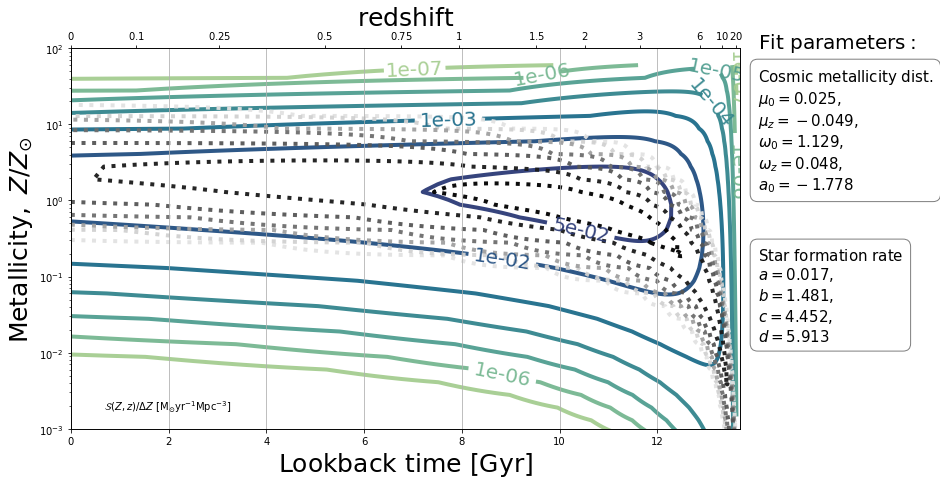

In [19]:
# Create the Figure
fig, ax = plt.subplots(1, 1, figsize = (12, 7))

"""
#add TNG contours
tng_color = sns.light_palette("#fe875d", as_cmap=True, n_colors = 7) # construct smooth cmap from one colour
TNG = ax.pcolormesh(Obs_Lookbacktimes, Obs_center_Zbin/Zsun, Obs_cosmic_SFR/step_obs_logZ, 
                                rasterized=True, norm=matplotlib.colors.LogNorm(vmin=1e-8,vmax=1e-1), 
                                cmap=tng_color, alpha=0.95 ) #matplotlib.cm.YlGnBu
#cbaxes1 = fig.add_axes([0.925, 0.1, 0.03, 0.8]) #[left, bottom, width, height]
cbaxes1 = fig.add_axes([0.12, 0.0, 0.8, 0.03]) #[left, bottom, width, height]
cb = plt.colorbar(TNG, cax = cbaxes1, label= r"$\mathrm{TNG \ SFRD/\Delta Z \ [M_{\odot} yr^{-1} Mpc^{-3}]}$", 
                 orientation='horizontal')
"""

####

#Plot dPdZ contours
dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                            Z_SFRD.skew_metallicity_distribution(high_res_redshifts, mu_0=mu_0, mu_z=mu_z,alpha = alpha, 
                                                          omega_0=omega_0, omega_z =omega_z, 
                                                          metals = high_res_metals)
# Get the SFR
sfr        = Z_SFRD.Madau_Dickinson2014(high_res_redshifts, a=sf_a, b=sf_b, c=sf_c,  d=sf_d) # Msun year-1 Mpc-3 
# Combine it into a SFRD
model_SFRD = (sfr* dPdlogZ.T).value

# Plot the contours of your Z-dep SFRD
COMPAS_cmap = sns.color_palette('crest', as_cmap=True)
cs = ax.contour(high_res_t, high_res_metals/Zsun, model_SFRD/step_logZ, levels, linewidths=4, cmap=COMPAS_cmap,
                             locator=ticker.LogLocator(), alpha = 0.95, zorder=0)
ax.clabel(cs,inline=1,fontsize=20, levels = levels, use_clabeltext=True, fmt = '%.0e')


# print all fit values on side of plot
ax.text(0.92, 0.88, '$\mathrm{Fit \ parameters:}$',  fontsize=20, transform=plt.gcf().transFigure)
# dPdZ
ax.text(0.92, 0.6, fit_values_string, fontsize=15, transform=plt.gcf().transFigure,
                   bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=0.5'))
# SFR
ax.text(0.92, 0.3, SFR_fit_string, fontsize=15, transform=plt.gcf().transFigure,
                   bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=0.5'))

####

# Neijssel 2019
# Get the data for Z-dep SFRD

# Get dPdZ   
neijssel_dPdlogZ, neijssel_metallicities, neijssel_step_logZ, p_draw_metallicity = \
                            Z_SFRD.skew_metallicity_distribution(high_res_redshifts, mu_0=0.035, mu_z=-0.23, alpha = 0, omega_0=0.39, omega_z =0, 
                                min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01, metals=high_res_metals)
# Get the SFR Neijssel et al 2019:
neijssel_sfr = Z_SFRD.Madau_Dickinson2014(high_res_redshifts, a=0.01, b=2.77, c=2.9, d=4.7) # Msun year-1 Mpc-3 
Neijssel_SFRDzZ = (neijssel_sfr* neijssel_dPdlogZ.T).value

greys = cm.get_cmap('Greys')
greys = greys(np.linspace(0.2,1,10)) # Don't start the cmap in white
cs_N = ax.contour(high_res_t, high_res_metals/Zsun, Neijssel_SFRDzZ, levels, linewidths=4,linestyles =':', alpha = 0.95, zorder=0,
                              cmap=ListedColormap(greys),locator=ticker.LogLocator())

#####

# Axes formatting for top panel
ax.text(0.05, 0.05, r"$ \mathcal{S}(Z,z)/ \Delta Z \ \mathrm{[M_{\odot} yr^{-1} Mpc^{-3}]}$", transform=ax.transAxes)
ax.xaxis.grid(5) # vertical lines
ax.set_yscale('log')
ax.set_xlabel('$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 25)
ax.set_ylabel(r'$\mathrm{Metallicity}, \ Z/Z_{\rm{\odot}}$', fontsize = 25)
  

# Add redshift axis
ax2 = ax.twiny()
 
# Annotate the tick labels
redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, 10, 20]
ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list])
ax2.set_xlabel('$\mathrm{redshift}$', fontsize = 25)

#Make sure top and bottom axis are lined up (have same limits)
ax.set_xlim(tmin, tmax)
ax2.set_xlim(tmin, tmax)

ax.set_ylim(1e-3, 1e2)

(-2.5, 1.5)

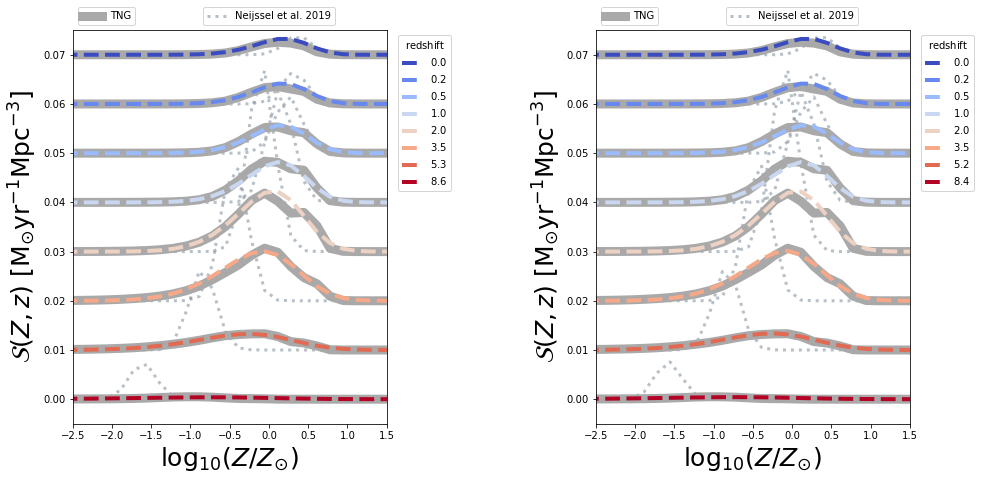

In [20]:
#Plot the bottom two panels from fig 1, version using TNGredshifts instead of Obs_redshifts calculated from TNGlookbacktime

fig = plt.figure(figsize = (15,15))
gs = gridspec.GridSpec(10, 8)
gs.update(wspace=0.0, hspace=0.5)
ax_metals = plt.subplot(gs[5:, :3])
ax_metals2  = plt.subplot(gs[5:, 5:8])

#Get Z dependent SFRD at same resolution as the TNG
low_res_dPdlogZ, low_res_metallicities, step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(Obs_redshifts, mu_0=mu_0, mu_z=mu_z,alpha = alpha, 
                                                      omega_0=omega_0, omega_z =omega_z, min_logZ  =min_logZ, max_logZ  =max_logZ, step_logZ = step_logZ,
                                                      metals = Obs_center_Zbin)
#  SFR
low_res_sfr = Z_SFRD.Madau_Dickinson2014(Obs_redshifts, a=sf_a, b=sf_b, c=sf_c,  d=sf_d) # Msun year-1 Mpc-3 
# Combine it into a SFRD
low_res_model_SFRD = (low_res_sfr* (low_res_dPdlogZ * step_logZ ).T).value

# Neijssel +2019
#  dPdZ   
low_res_neijssel_dPdlogZ, low_res_neijssel_metallicities, neijssel_step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(Obs_redshifts, mu_0=0.035, mu_z=-0.23, alpha = 0, omega_0=0.39, omega_z =0, 
                            min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01, metals=Obs_center_Zbin)
#  SFR Neijssel et al 2019:
low_res_neijssel_sfr    = Z_SFRD.Madau_Dickinson2014(Obs_redshifts, a=0.01, b=2.77, c=2.9, d=4.7) # Msun year-1 Mpc-3 
low_res_Neijssel_SFRDzZ = (low_res_neijssel_sfr*(low_res_neijssel_dPdlogZ*neijssel_step_logZ).T).value


#Let panel plot
redshifts_to_plot = [0,0.2, 0.5, 1, 2.01, 3.51, 5.27, 8.58]
redshift_indces   = [np.where(np.round(Obs_redshifts,2) == x)[0][0] for x in redshifts_to_plot]
colors     = plt.cm.coolwarm(np.linspace(0.,1.0, len(redshift_indces))) #3rd num is the number of colours
LAB = 'TNG'
plot_lines = []

# Plot a set of redshifts with offset
for i, redshift_i in enumerate(redshift_indces):
    if i != 0:
        LAB = None
    # The offset on the y-axis 
    shift_step = (len(redshift_indces)-1)*0.01 - 0.01*i 
    ######################################
    # Observed: TNG data
    ax_metals.plot(np.log10(Obs_center_Zbin/Zsun), Obs_cosmic_SFR[:,redshift_i] + shift_step,
                                 lw = 9, c = 'darkgrey', label = LAB)  

    ######################################
    # Model: new SFRD
    l = ax_metals.plot(np.log10(low_res_metallicities/Zsun), low_res_model_SFRD[:,redshift_i] + shift_step,
                           lw = 4, ls = '--', c = colors[i], label = "$z=%s$"%(np.round(Obs_redshifts[redshift_i], 1)) ) 
    
    ax_metals.plot(np.log10(low_res_metallicities/Zsun), low_res_Neijssel_SFRDzZ[:,redshift_i] + shift_step,
                                 lw = 3, c = 'slategrey', ls = ':', zorder=0, alpha = 0.5)  
    
    plot_lines.append([l])

# Plotvalues for bottom left panel
######################################
lines = ax_metals.get_lines()
legend1 = ax_metals.legend(lines[0:1], ['TNG','TNG'],
                         bbox_to_anchor=(0.0, 1.0), loc='lower left')
ax_metals.add_artist(legend1)
        
legend2 = ax_metals.legend(lines[2:3], ['Neijssel et al. 2019',' c'],
                         bbox_to_anchor=(0.4, 1.0), loc='lower left')
ax_metals.add_artist(legend2)
        
legend3 = ax_metals.legend(lines[1::3], ["$%s$"%(np.round(Obs_redshifts[redshift_i], 1)) for redshift_i in redshift_indces],
                         ncol=1, bbox_to_anchor=(1.02, 1), loc='upper left', title=r'$\mathrm{redshift}$')
        
ax_metals.set_xlabel(r'$\log_{10}(Z/Z_{\odot})$', size =25)
ax_metals.set_ylabel(r"$ \mathcal{S}(Z,z) \ \mathrm{[M_{\odot} yr^{-1} Mpc^{-3}]}$", size =25)
ax_metals.set_ylim(-0.005, 0.075)
ax_metals.set_xlim(-2.5, 1.5)#-0.5)

#####Second plot with TNGredshifts

#Get Z dependent SFRD at same resolution as the TNG
low_res_dPdlogZ, low_res_metallicities, step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(TNGredshifts, mu_0=mu_0, mu_z=mu_z,alpha = alpha, 
                                                      omega_0=omega_0, omega_z =omega_z, min_logZ  =min_logZ, max_logZ  =max_logZ, step_logZ = step_logZ,
                                                      metals = Obs_center_Zbin)
#  SFR
low_res_sfr = Z_SFRD.Madau_Dickinson2014(TNGredshifts, a=sf_a, b=sf_b, c=sf_c,  d=sf_d) # Msun year-1 Mpc-3 
# Combine it into a SFRD
low_res_model_SFRD = (low_res_sfr* (low_res_dPdlogZ * step_logZ ).T).value

# Neijssel +2019
#  dPdZ   
low_res_neijssel_dPdlogZ, low_res_neijssel_metallicities, neijssel_step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(TNGredshifts, mu_0=0.035, mu_z=-0.23, alpha = 0, omega_0=0.39, omega_z =0, 
                            min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01, metals=Obs_center_Zbin)
#  SFR Neijssel et al 2019:
low_res_neijssel_sfr    = Z_SFRD.Madau_Dickinson2014(TNGredshifts, a=0.01, b=2.77, c=2.9, d=4.7) # Msun year-1 Mpc-3 
low_res_Neijssel_SFRDzZ = (low_res_neijssel_sfr*(low_res_neijssel_dPdlogZ*neijssel_step_logZ).T).value


#Left panel plot
redshifts_to_plot = [0,0.2, 0.5, 1, 2.0, 3.49, 5.23, 8.45]
redshift_indces   = [np.where(np.round(TNGredshifts,2) == x)[0][0] for x in redshifts_to_plot]
colors     = plt.cm.coolwarm(np.linspace(0.,1.0, len(redshift_indces))) #3rd num is the number of colours
LAB = 'TNG'
plot_lines = []

# Plot a set of redshifts with offset
for i, redshift_i in enumerate(redshift_indces):
    if i != 0:
        LAB = None
    # The offset on the y-axis 
    shift_step = (len(redshift_indces)-1)*0.01 - 0.01*i 
    ######################################
    # Observed: TNG data
    ax_metals2.plot(np.log10(Obs_center_Zbin/Zsun), Obs_cosmic_SFR[:,redshift_i] + shift_step,
                                 lw = 9, c = 'darkgrey', label = LAB)  

    ######################################
    # Model: new SFRD
    l = ax_metals2.plot(np.log10(low_res_metallicities/Zsun), low_res_model_SFRD[:,redshift_i] + shift_step,
                           lw = 4, ls = '--', c = colors[i], label = "$z=%s$"%(np.round(TNGredshifts[redshift_i], 1)) ) 
    
    ax_metals2.plot(np.log10(low_res_metallicities/Zsun), low_res_Neijssel_SFRDzZ[:,redshift_i] + shift_step,
                                 lw = 3, c = 'slategrey', ls = ':', zorder=0, alpha = 0.5)  
    
    plot_lines.append([l])

# Plotvalues for bottom left panel
######################################
lines = ax_metals2.get_lines()
legend1 = ax_metals2.legend(lines[0:1], ['TNG','TNG'],
                         bbox_to_anchor=(0.0, 1.0), loc='lower left')
ax_metals2.add_artist(legend1)
        
legend2 = ax_metals2.legend(lines[2:3], ['Neijssel et al. 2019',' c'],
                         bbox_to_anchor=(0.4, 1.0), loc='lower left')
ax_metals2.add_artist(legend2)
        
legend3 = ax_metals2.legend(lines[1::3], ["$%s$"%(np.round(TNGredshifts[redshift_i], 1)) for redshift_i in redshift_indces],
                         ncol=1, bbox_to_anchor=(1.02, 1), loc='upper left', title=r'$\mathrm{redshift}$')
        
ax_metals2.set_xlabel(r'$\log_{10}(Z/Z_{\odot})$', size =25)
ax_metals2.set_ylabel(r"$ \mathcal{S}(Z,z) \ \mathrm{[M_{\odot} yr^{-1} Mpc^{-3}]}$", size =25)
ax_metals2.set_ylim(-0.005, 0.075)
ax_metals2.set_xlim(-2.5, 1.5)#-0.5)

(-0.005, 0.075)

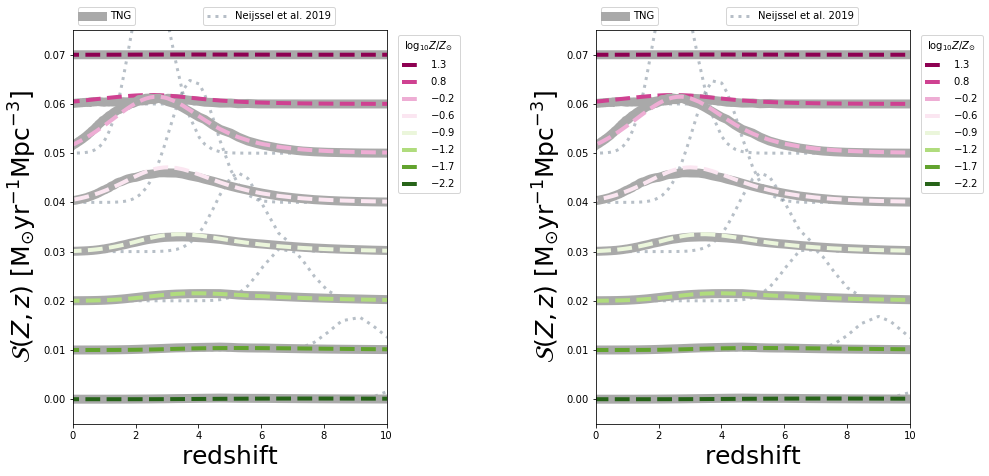

In [21]:
#Plot the bottom right panel from fig 1

fig = plt.figure(figsize = (15,15))
gs = gridspec.GridSpec(10, 8)
gs.update(wspace=0.0, hspace=0.5)
ax_redshifts = plt.subplot(gs[5:, :3])
ax_redshifts2  = plt.subplot(gs[5:, 5:8])

#Get Z dependent SFRD at same resolution as the TNG
low_res_dPdlogZ, low_res_metallicities, step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(Obs_redshifts, mu_0=mu_0, mu_z=mu_z,alpha = alpha, 
                                                      omega_0=omega_0, omega_z =omega_z, min_logZ  =min_logZ, max_logZ  =max_logZ, step_logZ = step_logZ,
                                                      metals = Obs_center_Zbin)
#  SFR
low_res_sfr = Z_SFRD.Madau_Dickinson2014(Obs_redshifts, a=sf_a, b=sf_b, c=sf_c,  d=sf_d) # Msun year-1 Mpc-3 
# Combine it into a SFRD
low_res_model_SFRD = (low_res_sfr* (low_res_dPdlogZ * step_logZ ).T).value

# Neijssel +2019
#  dPdZ   
low_res_neijssel_dPdlogZ, low_res_neijssel_metallicities, neijssel_step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(Obs_redshifts, mu_0=0.035, mu_z=-0.23, alpha = 0, omega_0=0.39, omega_z =0, 
                            min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01, metals=Obs_center_Zbin)
#  SFR Neijssel et al 2019:
low_res_neijssel_sfr    = Z_SFRD.Madau_Dickinson2014(Obs_redshifts, a=0.01, b=2.77, c=2.9, d=4.7) # Msun year-1 Mpc-3 
low_res_Neijssel_SFRDzZ = (low_res_neijssel_sfr*(low_res_neijssel_dPdlogZ*neijssel_step_logZ).T).value


#######

#Right panel plot
logmetals_to_plot = [-0.58, -1.08, -2.08, -2.41, -2.74, -3.08, -3.58, -4.08]
metal_indices   = [np.where(np.round(np.log10(Obs_center_Zbin),2) == x)[0][0] for x in logmetals_to_plot]
colors     = plt.cm.PiYG(np.linspace(0.,1.0, len(metal_indices))) #3rd num is the number of colours
LAB = 'TNG'
plot_lines = []

# Plot a set of redshifts with offset
for i, metal_i in enumerate(metal_indices):
    if i != 0:
        LAB = None
    # The offset on the y-axis 
    shift_step = (len(metal_indices)-1)*0.01 - 0.01*i
    ######################################
    # Observed: TNG data
    ax_redshifts.plot(Obs_redshifts, Obs_cosmic_SFR[metal_i,:] + shift_step,
                                 lw = 9, c = 'darkgrey', label = LAB)  

    ######################################
    # Model: new SFRD
    l = ax_redshifts.plot(Obs_redshifts, low_res_model_SFRD[metal_i,:] + shift_step,
                           lw = 4, ls = '--', c = colors[i] )    
    plot_lines.append([l])
    
    ax_redshifts.plot(Obs_redshifts, low_res_Neijssel_SFRDzZ[metal_i,:] + shift_step,
                                 lw = 3, c = 'slategrey', ls = ':', zorder=0, alpha = 0.5)
    
    plot_lines.append([l])

# Plotvalues for bottom left panel
######################################
lines = ax_redshifts.get_lines()
legend1 = ax_redshifts.legend(lines[0:1], ['TNG','TNG'],
                         bbox_to_anchor=(0.0, 1.0), loc='lower left')
ax_redshifts.add_artist(legend1)
        
legend2 = ax_redshifts.legend(lines[2:3], ['Neijssel et al. 2019',' c'],
                         bbox_to_anchor=(0.4, 1.0), loc='lower left')
ax_redshifts.add_artist(legend2)
        
legend3 = ax_redshifts.legend(lines[1::3], ["$%s$"%(np.round(np.log10(Obs_center_Zbin[metal_i]/Zsun), 1)) for metal_i in metal_indices],
                         ncol=1, bbox_to_anchor=(1.02, 1), loc='upper left', title=r'$\log_{10}Z/Z_{\rm{\odot}}$')
        
ax_redshifts.set_xlabel(r'$\mathrm{redshift}$', size =25)
ax_redshifts.set_ylabel(r"$ \mathcal{S}(Z,z) \ \mathrm{[M_{\odot} yr^{-1} Mpc^{-3}]}$", size =25)
        
ax_redshifts.set_xlim(0, 10)
ax_redshifts.set_ylim(-0.005, 0.075)


###################################
#Using TNGredshifts

#Get Z dependent SFRD at same resolution as the TNG
low_res_dPdlogZ, low_res_metallicities, step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(TNGredshifts, mu_0=mu_0, mu_z=mu_z,alpha = alpha, 
                                                      omega_0=omega_0, omega_z =omega_z, min_logZ  =min_logZ, max_logZ  =max_logZ, step_logZ = step_logZ,
                                                      metals = Obs_center_Zbin)
#  SFR
low_res_sfr = Z_SFRD.Madau_Dickinson2014(TNGredshifts, a=sf_a, b=sf_b, c=sf_c,  d=sf_d) # Msun year-1 Mpc-3 
# Combine it into a SFRD
low_res_model_SFRD = (low_res_sfr* (low_res_dPdlogZ * step_logZ ).T).value

# Neijssel +2019
#  dPdZ   
low_res_neijssel_dPdlogZ, low_res_neijssel_metallicities, neijssel_step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(TNGredshifts, mu_0=0.035, mu_z=-0.23, alpha = 0, omega_0=0.39, omega_z =0, 
                            min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01, metals=Obs_center_Zbin)
#  SFR Neijssel et al 2019:
low_res_neijssel_sfr    = Z_SFRD.Madau_Dickinson2014(TNGredshifts, a=0.01, b=2.77, c=2.9, d=4.7) # Msun year-1 Mpc-3 
low_res_Neijssel_SFRDzZ = (low_res_neijssel_sfr*(low_res_neijssel_dPdlogZ*neijssel_step_logZ).T).value


#######

#Right panel plot
logmetals_to_plot = [-0.58, -1.08, -2.08, -2.41, -2.74, -3.08, -3.58, -4.08]
metal_indices   = [np.where(np.round(np.log10(Obs_center_Zbin),2) == x)[0][0] for x in logmetals_to_plot]
colors     = plt.cm.PiYG(np.linspace(0.,1.0, len(metal_indices))) #3rd num is the number of colours
LAB = 'TNG'
plot_lines = []

# Plot a set of redshifts with offset
for i, metal_i in enumerate(metal_indices):
    if i != 0:
        LAB = None
    # The offset on the y-axis 
    shift_step = (len(metal_indices)-1)*0.01 - 0.01*i
    ######################################
    # Observed: TNG data
    ax_redshifts2.plot(TNGredshifts, Obs_cosmic_SFR[metal_i,:] + shift_step,
                                 lw = 9, c = 'darkgrey', label = LAB)  

    ######################################
    # Model: new SFRD
    l = ax_redshifts2.plot(TNGredshifts, low_res_model_SFRD[metal_i,:] + shift_step,
                           lw = 4, ls = '--', c = colors[i] )    
    plot_lines.append([l])
    
    ax_redshifts2.plot(TNGredshifts, low_res_Neijssel_SFRDzZ[metal_i,:] + shift_step,
                                 lw = 3, c = 'slategrey', ls = ':', zorder=0, alpha = 0.5)
    
    plot_lines.append([l])

# Plotvalues for bottom left panel
######################################
lines = ax_redshifts2.get_lines()
legend1 = ax_redshifts2.legend(lines[0:1], ['TNG','TNG'],
                         bbox_to_anchor=(0.0, 1.0), loc='lower left')
ax_redshifts2.add_artist(legend1)
        
legend2 = ax_redshifts2.legend(lines[2:3], ['Neijssel et al. 2019',' c'],
                         bbox_to_anchor=(0.4, 1.0), loc='lower left')
ax_redshifts2.add_artist(legend2)
        
legend3 = ax_redshifts2.legend(lines[1::3], ["$%s$"%(np.round(np.log10(Obs_center_Zbin[metal_i]/Zsun), 1)) for metal_i in metal_indices],
                         ncol=1, bbox_to_anchor=(1.02, 1), loc='upper left', title=r'$\log_{10}Z/Z_{\rm{\odot}}$')
        
ax_redshifts2.set_xlabel(r'$\mathrm{redshift}$', size =25)
ax_redshifts2.set_ylabel(r"$ \mathcal{S}(Z,z) \ \mathrm{[M_{\odot} yr^{-1} Mpc^{-3}]}$", size =25)
        
ax_redshifts2.set_xlim(0, 10)
ax_redshifts2.set_ylim(-0.005, 0.075)

## Figure 2: Comparison of SFRD(z)

In [22]:
def powerlaw_fit_Chruslinska21(z_bounds= [0,1.0,1.8,4.0,7.0,8.8, 10.0], 
                                   kappa_list = [2.3822, 2.2105, -1.2278,-2.4769, -12.5280, 0],
                                   A_list = [0.0248, 0.028, 0.964, 7.2, 8.6*10**9, 0.00328]):
        """
        Powerlaw approximation from Chruslinska +2021 (Fig. 11 and tables 3 and B2)
        Default values are upper edge of Cosmic SFH – SB: B18/C17 == Thick brown line in fig. 11
        """
        redshifts, SFRD = [], []
        for i in range(len(z_bounds) -1):
            z    = np.linspace(z_bounds[i], z_bounds[i+1], num = 20)
            z    = (z[:-1] + z[1:])/2.
            redshifts.append(z)
            
            vals = A_list[i] * (1 + z)**kappa_list[i]
            SFRD.append(A_list[i] * (1 + z)**kappa_list[i])
            
        redshifts = np.array(redshifts).flatten()
        SFRD      = np.array(SFRD).flatten()
        
        return redshifts, SFRD # Msun /yr /Mpc^3

In [23]:
def plot_SFR(sf_a = 0.017, sf_b = 1.481, sf_c = 4.452,  sf_d = 5.913, show_legend = True,
                 redshift_list  = np.linspace(0,15, num=100), x_redshift = True, show_powerlaw_fit = False,
                 tmin=0.0, tmax = 13.7, readTNG=False):
        ########################################################
        # Start plotting
        fig, ax = plt.subplots(figsize=(10,8))

        if x_redshift:
            x1  = redshift_list
        else:
            x1 = cosmo.lookback_time(redshift_list)

    #     #default M&D 14
    #     # Because MD14 was computed using a salpeter IMF, you need to correct the SFRD!
    #     salpeter_to_kroupa = (1./1.55) 
    #     ax.plot(x1, salpeter_to_kroupa*Z_SFRD.Madau_Dickinson2014(redshift_list), 
    #              label = 'Madau and Dickinson 2014\n $a=%.3f, b=%.2f, c=%.2f, d=%.2f$'% (0.015,2.7,2.9,5.6)
    #              , c = 'royalblue', ls = '--',lw=2)

        #default Madau & Fragos 17
        ax.plot(x1, Z_SFRD.Madau_Dickinson2014(redshift_list, a=0.01, b=2.6, c=3.2, d=6.2), 
                 label = 'Madau and Fragos 2017'+'\n'+'$a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.01,2.6,3.2,6.2)
                 , c = 'grey', ls = ':',lw=6)

    #     #default Coen
    #     ax.plot(x1, Z_SFRD.Madau_Dickinson2014(redshift_list, a=0.01, b=2.77, c=2.9, d=4.7), 
    #              label = 'Neijssel et al 2019\n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.01,2.77,2.9,4.7)
    #              , c = '#aacfdd', lw=5, ls = '--')

        #########
        # Approximate max SFRD
        if show_powerlaw_fit:
            # --> Thick brown line in Fig. 11 Chruslinska + 2021 (models: 30*f14SBBiC)
            upper_redshifts, upper_SFRD = powerlaw_fit_Chruslinska21()
            if x_redshift:
                upper_x = upper_redshifts
            else:
                upper_x = cosmo.lookback_time(upper_redshifts)
            ax.plot(upper_x, upper_SFRD, 
                 # label = r'$\rm{Max \ SFR, \ Chruslinska \ et \ al. \ 2021: (SB: \ B18/C17)}$',
                 label = 'Max  SFR,  Chruslinska  et  al.  2021: (SB:  B18/C17)',
                    c = 'brown', lw=5, ls = '-.')

        #Resembling thick brown line in Fig. 11 Chruslinska + 2021
        a_max, b_max, c_max, d_max = 0.025,2.6,3.3,5.9 #2.5,2.9,4.5 
        ax.plot(x1, Z_SFRD.Madau_Dickinson2014(redshift_list, a=a_max, b=b_max, c=c_max, d=d_max), 
                 label = 'Approx. to  upper limit:'+'\n'+'$a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (a_max, b_max, c_max, d_max)
                 , c = '#356288', lw=5, ls = '-')

        # BEST FIT
        try:
            y_vals = Z_SFRD.Madau_Dickinson2014(redshift_list, a=sf_a, b=sf_b, c=sf_c,  d=sf_d)
            ax.plot(x1, y_vals,label = 'Using best fit parameters (fiducial)'+'\n'+'$a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (sf_a,sf_b,sf_c, sf_d), 
                     c = '#fe1100', lw=5, ls = '--', zorder =10)
            print('max value', y_vals[np.argmax(y_vals)], ' at x_max = ', x1[np.argmax(y_vals)])
        except:
            print('you probably havent run the optimzation yet..')



        ######################################
        # read TNG data
        ######################################
        with h5.File(TNGlocation+"/SFRMetallicityFromGasTNG100.hdf5", "r") as f:
            MetalBins     = f["MetalBins"][:]
            Lookbacktimes = f["Lookbacktimes"][:]
            BoxSfr        = f["Sfr"][:]
            Redshifts     = f["Redshifts"][:]
        # Convert SFR from sfr/box to sfr Mpc-3
        littleh  = 0.6774
        Rbox     = 75/littleh
        TNG_SFRD = BoxSfr / Rbox**3 *u.Mpc**-3
        TNG_SFRD = TNG_SFRD.value
        # the last value of Lookbacktimes = 0, which is problematic for z calculation
        redshifts_TNG = [z_at_value(cosmo.lookback_time,t*u.Gyr,method='Bounded') for t in Lookbacktimes[:-1]] 
        redshifts_TNG.append(0) # put redshift zero back at the end
        redshifts_TNG = np.array(redshifts_TNG)
        if readTNG == True:
            redshifts_TNG = Redshifts
        redshifts_TNG_inc = redshifts_TNG[::-1]
        ##########################################
        # "observed" TNG SFR(z)
        ##########################################
        if x_redshift:
            xobs  = redshifts_TNG
            #xobs2 = Redshifts
        else:
            xobs = Lookbacktimes

        ax.plot(xobs, np.sum(TNG_SFRD,axis=1), label = 'TNG100', c = '#fe875d', lw=6)

        ##########################################
        # Checking normalization of what I will fit
        ##########################################################################
        center_Zbin = (MetalBins[:-1] + MetalBins[1:])/2.
        sfr = Z_SFRD.Madau_Dickinson2014(redshifts_TNG_inc, a=0.01, b=2.6, c=3.2,  d=6.2) # Msun year-1 Mpc-3 
        # Get dPdZ 
        dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(redshifts_TNG_inc, mu_z =-0.1, mu_0 =0.025,
                                                      omega_0=1.9,omega_z=1.9, alpha =-1.7, 
                                                      metals=center_Zbin)

        if x_redshift:
            x  = redshifts_TNG_inc
        else:
            x = cosmo.lookback_time(redshifts_TNG_inc)

        # For each redshift in the TNG data:
        for redshift_i in range(len(redshifts_TNG_inc)):
            SFRD = sfr[redshift_i] *dPdlogZ[redshift_i,:]#* step_logZ
            #plt.scatter(x[redshift_i], np.sum(SFRD), c = 'r')
            #
        ##########################################################################


        #### Age Universe Axis ####
        #ax2 = ax.twiny()

        if x_redshift:
            ###################
            #Plotvalues
            ax.set_xlabel(r'$\mathrm{redshift}$', fontsize = 30)

            # Find loockback location for each of our redshifts
            # redshift_tick_list = [0, 0.5, 2, 3, 6, 10, 12]#[0, 0.5, 1.0, 1.5, 2, 3, 6, 10, 12]
            redshift_tick_list = [0, 2, 6, 10, 12]#[0, 0.5, 1.0, 1.5, 2, 3, 6, 10, 12]
            # And annotate the tick labels :)
            #ax2.set_xticks([z for z in redshift_tick_list])
            #ax2.set_xticklabels(['${:.1f}$'.format(cosmo.lookback_time(z).value) for z in redshift_tick_list], fontsize = 24)
            # ax2.set_xlabel(r'$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 30)
            #ax2.set_xlabel('Lookback time [Gyr]', fontsize = 30)

        else:
            ###################
            #Plotvalues
            # ax.set_xlabel(r'$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 30)
            ax.set_xlabel('Lookback time [Gyr]', fontsize = 30)
            
            redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, ]
            # Find loockback location for each of our ages
            z_ticks = [cosmo.lookback_time(z) for z in redshift_tick_list]

            # And annotate the tick labels :)
            #ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
            #ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list], fontsize = 24)
            # ax2.set_xlabel(r'$\mathrm{redshift}$', fontsize = 30)
            #ax2.set_xlabel('redshift', fontsize = 30)


        ##########################################################################
        ax.xaxis.grid(5) # vertical lines
        # Make sure top and bottom axis are lined up (have same limmits)
        ax.set_xlim(tmin, tmax)
        #ax2.set_xlim(tmin, tmax)
        logy = True
        if logy:
            plt.yscale('log')
        ax.set_ylabel(r'$dM/dt dV_c$ $\mathrm{[M_{\odot} yr^{-1} Mpc^{-3}]}$', fontsize = 30)
        ax.yaxis.set_tick_params(labelsize=24)
        ax.set_ylim(1e-3, 1.)
        if show_legend:
            ax.legend()
        if x_redshift:
            print('saving here', save_loc + 'SFR_redshift'+'.pdf')
            plt.savefig(save_loc + 'SFR_redshift'+'.pdf',  bbox_inches='tight')
        else:
            print('saving here', save_loc + 'SFR_tlookback'+'.pdf')
            plt.savefig(save_loc + 'SFR_tlookback'+'.pdf',  bbox_inches='tight')
        
        # plt.show()

In [24]:
def plot_SFR_both(sf_a = 0.017, sf_b = 1.481, sf_c = 4.452,  sf_d = 5.913, show_legend = True,
                 redshift_list  = np.linspace(0,15, num=100), x_redshift = True, show_powerlaw_fit = False,
                 tmin=0.0, tmax = 13.7):
        ########################################################
        # Start plotting
        fig, ax = plt.subplots(figsize=(10,8))

        if x_redshift:
            x1  = redshift_list
        else:
            x1 = cosmo.lookback_time(redshift_list)

    #     #default M&D 14
    #     # Because MD14 was computed using a salpeter IMF, you need to correct the SFRD!
    #     salpeter_to_kroupa = (1./1.55) 
    #     ax.plot(x1, salpeter_to_kroupa*Z_SFRD.Madau_Dickinson2014(redshift_list), 
    #              label = 'Madau and Dickinson 2014\n $a=%.3f, b=%.2f, c=%.2f, d=%.2f$'% (0.015,2.7,2.9,5.6)
    #              , c = 'royalblue', ls = '--',lw=2)

        #default Madau & Fragos 17
        ax.plot(x1, Z_SFRD.Madau_Dickinson2014(redshift_list, a=0.01, b=2.6, c=3.2, d=6.2), 
                 label = 'Madau and Fragos 2017'+'\n'+'$a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.01,2.6,3.2,6.2)
                 , c = 'grey', ls = ':',lw=6)

    #     #default Coen
    #     ax.plot(x1, Z_SFRD.Madau_Dickinson2014(redshift_list, a=0.01, b=2.77, c=2.9, d=4.7), 
    #              label = 'Neijssel et al 2019\n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.01,2.77,2.9,4.7)
    #              , c = '#aacfdd', lw=5, ls = '--')

        #########
        # Approximate max SFRD
        if show_powerlaw_fit:
            # --> Thick brown line in Fig. 11 Chruslinska + 2021 (models: 30*f14SBBiC)
            upper_redshifts, upper_SFRD = powerlaw_fit_Chruslinska21()
            if x_redshift:
                upper_x = upper_redshifts
            else:
                upper_x = cosmo.lookback_time(upper_redshifts)
            ax.plot(upper_x, upper_SFRD, 
                 # label = r'$\rm{Max \ SFR, \ Chruslinska \ et \ al. \ 2021: (SB: \ B18/C17)}$',
                 label = 'Max  SFR,  Chruslinska  et  al.  2021: (SB:  B18/C17)',
                    c = 'brown', lw=5, ls = '-.')

        #Resembling thick brown line in Fig. 11 Chruslinska + 2021
        a_max, b_max, c_max, d_max = 0.025,2.6,3.3,5.9 #2.5,2.9,4.5 
        ax.plot(x1, Z_SFRD.Madau_Dickinson2014(redshift_list, a=a_max, b=b_max, c=c_max, d=d_max), 
                 label = 'Approx. to  upper limit:'+'\n'+'$a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (a_max, b_max, c_max, d_max)
                 , c = '#356288', lw=5, ls = '-')

        # BEST FIT
        try:
            y_vals = Z_SFRD.Madau_Dickinson2014(redshift_list, a=sf_a, b=sf_b, c=sf_c,  d=sf_d)
            ax.plot(x1, y_vals,label = 'Using best fit parameters (fiducial)'+'\n'+'$a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (sf_a,sf_b,sf_c, sf_d), 
                     c = '#fe1100', lw=5, ls = '--', zorder =10)
            print('max value', y_vals[np.argmax(y_vals)], ' at x_max = ', x1[np.argmax(y_vals)])
        except:
            print('you probably havent run the optimzation yet..')



        ######################################
        # read TNG data
        ######################################
        with h5.File(TNGlocation+"/SFRMetallicityFromGasTNG100.hdf5", "r") as f:
            MetalBins     = f["MetalBins"][:]
            Lookbacktimes = f["Lookbacktimes"][:]
            BoxSfr        = f["Sfr"][:]
            Redshifts     = f["Redshifts"][:]
        # Convert SFR from sfr/box to sfr Mpc-3
        littleh  = 0.6774
        Rbox     = 75/littleh
        TNG_SFRD = BoxSfr / Rbox**3 *u.Mpc**-3
        TNG_SFRD = TNG_SFRD.value
        # the last value of Lookbacktimes = 0, which is problematic for z calculation
        redshifts_TNG = [z_at_value(cosmo.lookback_time,t*u.Gyr,method='Bounded') for t in Lookbacktimes[:-1]] 
        redshifts_TNG.append(0) # put redshift zero back at the end
        redshifts_TNG = np.array(redshifts_TNG)
                                 
        redshifts_TNG_inc = redshifts_TNG[::-1]
        redshifts_TNG_inc2 = Redshifts[::-1]
        ##########################################
        # "observed" TNG SFR(z)
        ##########################################
        if x_redshift:
            xobs  = redshifts_TNG
            xobs2 = Redshifts
        else:
            xobs = Lookbacktimes
            xobs2 = Lookbacktimes

        ax.plot(xobs, np.sum(TNG_SFRD,axis=1), label = 'TNG100 (calculated z)', c = '#fe875d', lw=6)
        ax.plot(xobs2, np.sum(TNG_SFRD,axis=1), label = 'TNG100 (read in z)', c = 'green', lw=6)

        ##########################################
        # Checking normalization of what I will fit
        ##########################################################################
        center_Zbin = (MetalBins[:-1] + MetalBins[1:])/2.
        sfr = Z_SFRD.Madau_Dickinson2014(redshifts_TNG_inc, a=0.01, b=2.6, c=3.2,  d=6.2) # Msun year-1 Mpc-3 
        sfr2 = Z_SFRD.Madau_Dickinson2014(redshifts_TNG_inc2, a=0.01, b=2.6, c=3.2,  d=6.2) # Msun year-1 Mpc-3 
        # Get dPdZ 
        dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(redshifts_TNG_inc, mu_z =-0.1, mu_0 =0.025,
                                                      omega_0=1.9,omega_z=1.9, alpha =-1.7, 
                                                      metals=center_Zbin)
                                 
        dPdlogZ2, metallicities2, step_logZ2, p_draw_metallicity2 = \
                        Z_SFRD.skew_metallicity_distribution(redshifts_TNG_inc2, mu_z =-0.1, mu_0 =0.025,
                                                      omega_0=1.9,omega_z=1.9, alpha =-1.7, 
                                                      metals=center_Zbin)

        if x_redshift:
            x  = redshifts_TNG_inc
            x2 = Redshifts
        else:
            x = cosmo.lookback_time(redshifts_TNG_inc)
            x2 = Lookbacktimes[::-1]

        # For each redshift in the TNG data:
        for redshift_i in range(len(redshifts_TNG_inc)):
            SFRD = sfr[redshift_i] *dPdlogZ[redshift_i,:]#* step_logZ
            #plt.scatter(x[redshift_i], np.sum(SFRD), c = 'r')
            #
                                 
        for redshift_i in range(len(redshifts_TNG_inc2)):
            SFRD2 = sfr2[redshift_i] *dPdlogZ2[redshift_i,:]
        ##########################################################################


        #### Age Universe Axis ####
        #ax2 = ax.twiny()

        if x_redshift:
            ###################
            #Plotvalues
            ax.set_xlabel(r'$\mathrm{redshift}$', fontsize = 30)

            # Find loockback location for each of our redshifts
            # redshift_tick_list = [0, 0.5, 2, 3, 6, 10, 12]#[0, 0.5, 1.0, 1.5, 2, 3, 6, 10, 12]
            redshift_tick_list = [0, 2, 6, 10, 12]#[0, 0.5, 1.0, 1.5, 2, 3, 6, 10, 12]
            # And annotate the tick labels :)
            #ax2.set_xticks([z for z in redshift_tick_list])
            #ax2.set_xticklabels(['${:.1f}$'.format(cosmo.lookback_time(z).value) for z in redshift_tick_list], fontsize = 24)
            # ax2.set_xlabel(r'$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 30)
            #ax2.set_xlabel('Lookback time [Gyr]', fontsize = 30)

        else:
            ###################
            #Plotvalues
            # ax.set_xlabel(r'$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 30)
            ax.set_xlabel('Lookback time [Gyr]', fontsize = 30)
            
            redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, ]
            # Find loockback location for each of our ages
            z_ticks = [cosmo.lookback_time(z) for z in redshift_tick_list]

            # And annotate the tick labels :)
            #ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
            #ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list], fontsize = 24)
            # ax2.set_xlabel(r'$\mathrm{redshift}$', fontsize = 30)
            #ax2.set_xlabel('redshift', fontsize = 30)


        ##########################################################################
        ax.xaxis.grid(5) # vertical lines
        # Make sure top and bottom axis are lined up (have same limmits)
        ax.set_xlim(tmin, tmax)
        #ax2.set_xlim(tmin, tmax)
        logy = True
        if logy:
            plt.yscale('log')
        ax.set_ylabel(r'$dM/dt dV_c$ $\mathrm{[M_{\odot} yr^{-1} Mpc^{-3}]}$', fontsize = 30)
        ax.yaxis.set_tick_params(labelsize=24)
        ax.set_ylim(1e-3, 1.)
        if show_legend:
            ax.legend()
        if x_redshift:
            print('saving here', save_loc + 'SFR_redshift'+'.pdf')
            plt.savefig(save_loc + 'SFR_redshift'+'.pdf',  bbox_inches='tight')
        else:
            print('saving here', save_loc + 'SFR_tlookback'+'.pdf')
            plt.savefig(save_loc + 'SFR_tlookback'+'.pdf',  bbox_inches='tight')
        
        # plt.show()

max value 0.0883961314673647 solMass / (Mpc3 yr)  at x_max =  11.411910500494313 Gyr


/home/sashalvna/research/Fit_SFRD_TNG100/get_ZdepSFRD.py:117: RuntimeWarning: invalid value encountered in true_divide
  dPdlogZ = dPdlogZ /norm[:,np.newaxis]


saving here ./SFR_tlookback.pdf


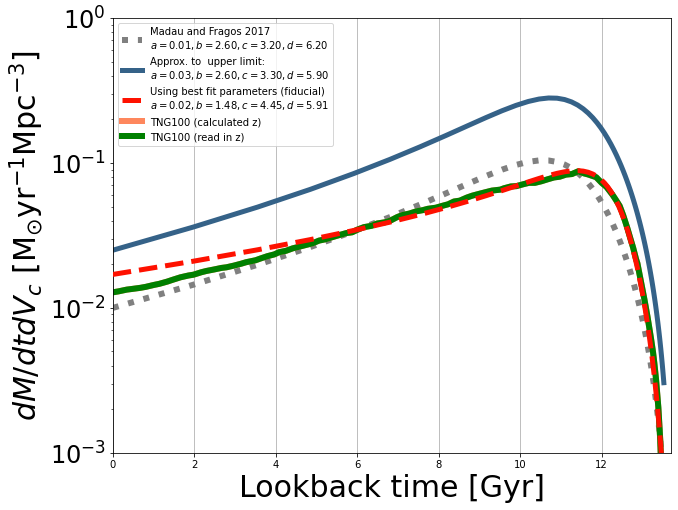

In [25]:
#time axis
save_loc = './'
plot_SFR_both(sf_a = sf_a, sf_b = sf_b, sf_c = sf_c,  sf_d = sf_d,show_legend = True,
             redshift_list  = np.linspace(0,15, num=100), x_redshift = False, tmin=0.0, tmax = 13.7)

max value 0.0883961314673647 solMass / (Mpc3 yr)  at x_max =  2.7272727272727275


/home/sashalvna/research/Fit_SFRD_TNG100/get_ZdepSFRD.py:117: RuntimeWarning: invalid value encountered in true_divide
  dPdlogZ = dPdlogZ /norm[:,np.newaxis]


saving here ./SFR_redshift.pdf


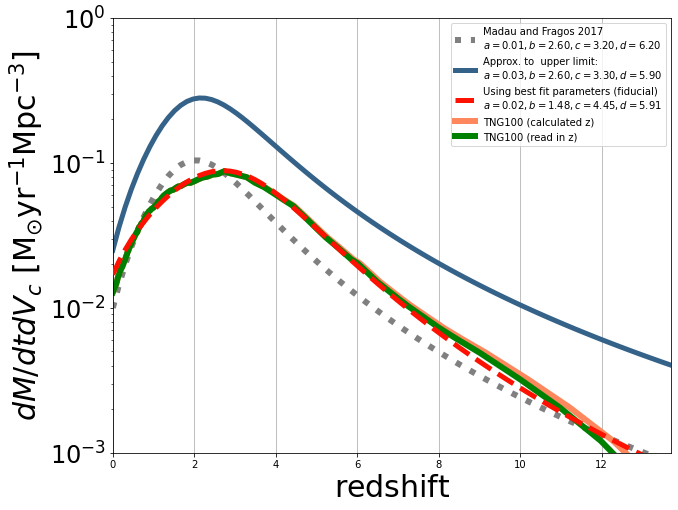

In [26]:
#redshift axis - only difference is x_redshift true/false (and legend)
plot_SFR_both(sf_a = sf_a, sf_b = sf_b, sf_c = sf_c,  sf_d = sf_d,show_legend = True,
             redshift_list  = np.linspace(0,15, num=100), x_redshift = True, tmin=0.0, tmax = 13.7)

## Figure 3: Stable BH primary mass distribution for variations of SFRD(Z, z) 

In [27]:
import matplotlib
matplotlib.use('Agg')

import seaborn as sns
from scipy import stats

# Chosen cosmology - now it's WMAP9??
# Update: plot mass distribution.py doesnt use cosmo or z_at_value, so can ignore here
#from astropy.cosmology import WMAP9 as cosmo
#from astropy.cosmology import z_at_value

import json
import argparse
import gc

# Custom scripts
import MassDistHelperFunctions as mfunc
import Plot_Mass_distributions as pltmass

In [28]:
## locations
save_loc    =  '/home/sashalvna/research/Fit_SFRD_TNG100'
data_dir    =  '/home/sashalvna/research/Fit_SFRD_TNG100/data'
rate_file_name = 'Rate_info.h5'
COMPASfilename = 'COMPAS_Output_wWeights.h5'

In [29]:
## PLOT setttings
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
from matplotlib import rc

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

In [30]:
#figure 3: stable MT, no unstable so no CE
only_stable = True 
only_CE     = False 
channel_string = 'stable'

plotting LIGO
Reading  /home/sashalvna/research/Fit_SFRD_TNG100/data//COMPAS_Output_wWeights.h5
Done with reading DCO data for this file :)
nplot 0 

rate_key Rates_mu00.025_muz-0.049_alpha-1.79_sigma00.7_sigmaz0.048_a0.017_b1.487_c4.442_d5.886_zBinned
using file with key CE_Event_Count
BBH_bool should already contain all stuff, np.sum(BBH_bool)  1640550  len(merging_BBH) 1640550
$\mathrm{Narrow: \ }  (\omega_0 = 0.70) \  \mathcal{R}_{0.2} = \ $  len(merging_BBH)= 449453  Rate =  6.288918259222756  Gpc-3 yr-1
get the histogram
rate_key Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048_a0.017_b1.487_c4.442_d5.886_zBinned
using file with key CE_Event_Count
BBH_bool should already contain all stuff, np.sum(BBH_bool)  1640550  len(merging_BBH) 1640550
$\mathrm{Fiducial: \ } (\omega_0 = 1.13) \ \mathcal{R}_{0.2}= \ $  len(merging_BBH)= 449453  Rate =  17.090613009974057  Gpc-3 yr-1
get the histogram
rate_key Rates_mu00.025_muz-0.049_alpha-1.79_sigma02.0_sigmaz0.048_a0.017_b1.487_c

using file with key CE_Event_Count
BBH_bool should already contain all stuff, np.sum(BBH_bool)  1640550  len(merging_BBH) 1640550
$\mathrm{Approx. \ to \ upper \ limit:}  \ \mathcal{R}_{0.2} = \ $  len(merging_BBH)= 449453  Rate =  55.60961519231055  Gpc-3 yr-1
get the histogram


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


m 1.241143036881848 [3.94136042] [1.22916342]

m 0.41848045046499616 [1.37681286] [0.41716421]

m 0.020615243080907564 [0.06798978] [0.0191641]



findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


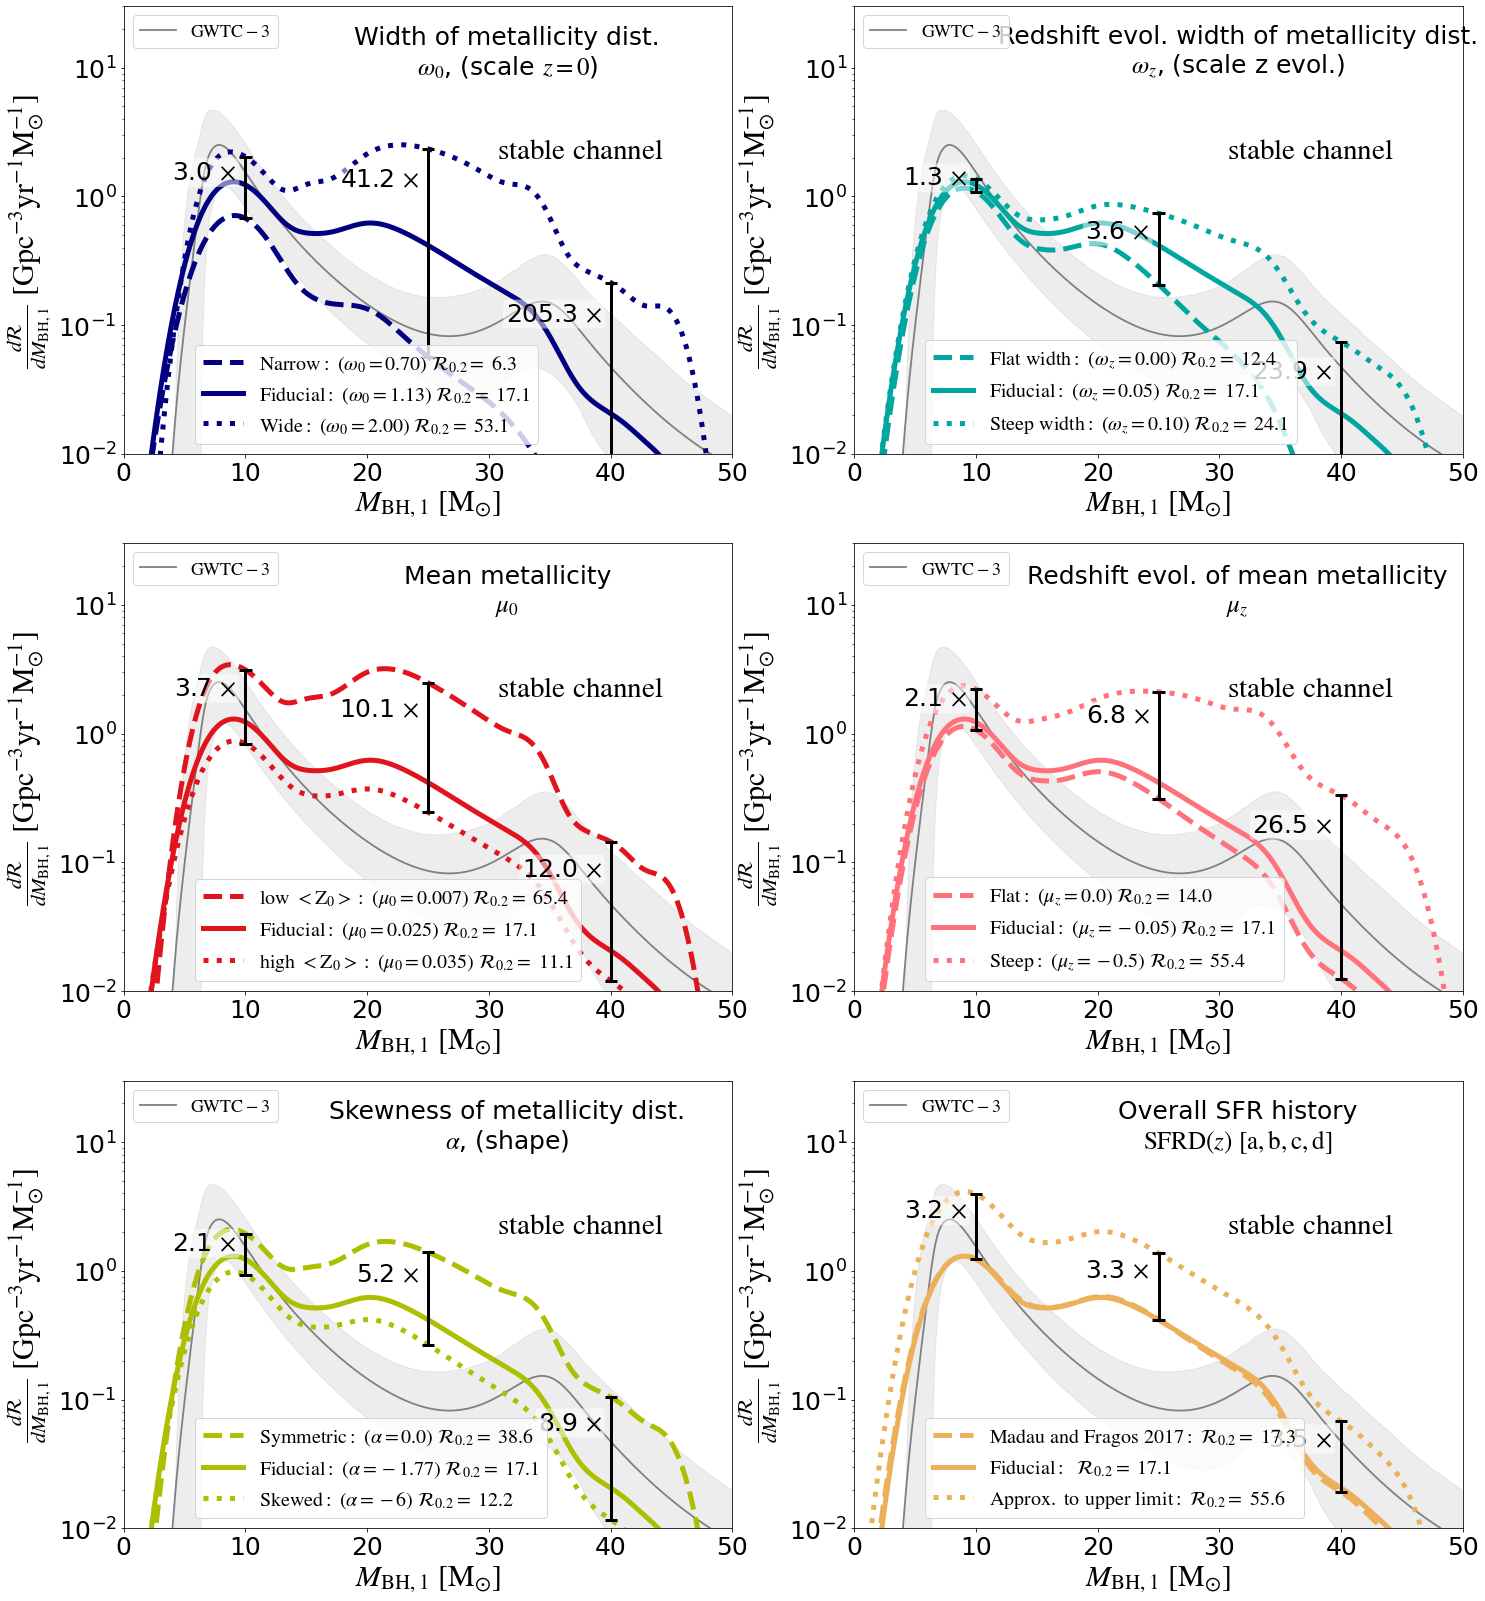

In [31]:
#plotting
fig = plt.figure( figsize = (24, 28))

# width of SFRD at z=0 - sigma0 varied
subplot1 = fig.add_subplot(321) #first subplot in layout that has 3 rows and 2 columns
ax1 = pltmass.plot_mass_distribution(sim_dir = data_dir, rate_file='/'+str(rate_file_name), simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys  = ['Rates_mu00.025_muz-0.049_alpha-1.79_sigma0%s_sigmaz0.048_a0.017_b1.487_c4.442_d5.886_zBinned'%(x) for x in [0.7, 1.129, 2.0]], channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color =  'navy',
                           only_CE = only_CE, only_stable = only_stable, 
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_width_variations.pdf', titletext = "Width of metallicity dist."+"\n"+r"$\omega_0$, (scale $z=0$)",
                           labels = [r'$\mathrm{Narrow: \ }  (\omega_0 = 0.70) \  \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \ } (\omega_0 = 1.13) \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Wide: \ } (\omega_0 = 2.00) \  \mathcal{R}_{0.2} = \ $'],
                          multipanel = True, subplot = subplot1)

# Redshift evolution of the width - sigma z varied
subplot2 = fig.add_subplot(322)
ax2 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz%s_a0.017_b1.487_c4.442_d5.886_zBinned'%(x) for x in [0.0, 0.048, 0.1]],channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#00a6a0', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_zevol_width_variations.pdf',  titletext = "Redshift evol. width of metallicity dist." +"\n"+ r"$\omega_z$, (scale z evol.)",
                           labels = [r'$\mathrm{Flat \ width: \ } (\omega_z = 0.00) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \ } (\omega_z = 0.05) \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Steep \ width: \ } (\omega_z = 0.10) \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot2)

# Mean metallicity at z=0 - mu0 varied
subplot3 = fig.add_subplot(323)
ax3 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu0%s_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048_a0.017_b1.487_c4.442_d5.886_zBinned'%(x) for x in [0.007, 0.025, 0.035]],channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#e1131d', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_meanZ_variations.pdf',  titletext = 'Mean metallicity'+"\n"+r"$\mu_0$",
                           labels = [r'$\mathrm{low \ <Z_0> : \ } (\mu_0 = 0.007) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial : \ }  (\mu_0 = 0.025) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{high \ <Z_0> : \ } (\mu_0 = 0.035) \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot3)

# Redshift evolution of mean metallicity - mu z varied
subplot4 = fig.add_subplot(324)
ax4 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu00.025_muz%s_alpha-1.79_sigma01.129_sigmaz0.048_a0.017_b1.487_c4.442_d5.886_zBinned'%(x) for x in [0.0, -0.049, -0.5]],channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#ff717b', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_zevol_mean_variations.pdf', titletext = "Redshift evol. of mean metallicity" +"\n"+ r"$\mu_z$", 
                           labels = [r'$\mathrm{Flat: \ }  (\mu_z = 0.0) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \ } (\mu_z = -0.05) \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Steep: \ } (\mu_z = -0.5) \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot4)

# Skewness - alpha varied
subplot5 = fig.add_subplot(325)
ax5 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu00.025_muz-0.049_alpha%s_sigma01.129_sigmaz0.048_a0.017_b1.487_c4.442_d5.886_zBinned'%(x) for x in [0.0, -1.79, -6.0]],channel_string = channel_string,
                           show_hist = False, show_KDE = True, plot_LIGO = True, Color = '#acbf00', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_skewness_variations.pdf', titletext = "Skewness of metallicity dist." +"\n"+ r"$\alpha$, (shape)", 
                           labels = [r'$\mathrm{Symmetric: \ } (\alpha = 0.0)   \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \  } (\alpha = -1.77)  \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Skewed: \    } (\alpha = -6)  \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot5)

# Star formation norm - SFRD(z) varied
subplot6 = fig.add_subplot(326)
ax6 = pltmass.plot_mass_distribution(sim_dir = data_dir, rate_file='/'+str(rate_file_name), simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  
                           rate_keys = ['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048_a0.01_b2.6_c3.2_d6.2_zBinned',
                                       'Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048_a0.017_b1.487_c4.442_d5.886_zBinned', 
                                       'Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048_a0.03_b2.6_c3.3_d5.9_zBinned'],
                                 channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#ecb05b', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_skewness_variations.pdf', titletext = "Overall SFR history"+"\n"+ r'$ \mathrm{SFRD(}z\rm{)} \ [a,b,c,d]$', 
                           labels = [r'$\mathrm{Madau \ and \ Fragos \ 2017: }  \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Fiducial: \ } \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Approx. \ to \ upper \ limit:}  \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot6)

## Figure 4: CE BH primary mass distribution for variations of SFRD(Z, z) 

In [32]:
#figure 4: unstable MT; CE
only_stable = False 
only_CE     = True 
channel_string = 'CE'

plotting LIGO
Reading  /home/sashalvna/research/Fit_SFRD_TNG100/data//COMPAS_Output_wWeights.h5
Done with reading DCO data for this file :)
nplot 0 

rate_key Rates_mu00.025_muz-0.049_alpha-1.79_sigma00.7_sigmaz0.048_a0.017_b1.487_c4.442_d5.886_zBinned
using file with key CE_Event_Count
BBH_bool should already contain all stuff, np.sum(BBH_bool)  1640550  len(merging_BBH) 1640550
$\mathrm{Narrow: \ }  (\omega_0 = 0.70) \  \mathcal{R}_{0.2} = \ $  len(merging_BBH)= 1187691  Rate =  24.221430930471904  Gpc-3 yr-1
get the histogram
rate_key Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048_a0.017_b1.487_c4.442_d5.886_zBinned
using file with key CE_Event_Count
BBH_bool should already contain all stuff, np.sum(BBH_bool)  1640550  len(merging_BBH) 1640550
$\mathrm{Fiducial: \ } (\omega_0 = 1.13) \ \mathcal{R}_{0.2}= \ $  len(merging_BBH)= 1187691  Rate =  41.82370458147471  Gpc-3 yr-1
get the histogram
rate_key Rates_mu00.025_muz-0.049_alpha-1.79_sigma02.0_sigmaz0.048_a0.017_b1.487

BBH_bool should already contain all stuff, np.sum(BBH_bool)  1640550  len(merging_BBH) 1640550
$\mathrm{Approx. \ to \ upper \ limit:}  \ \mathcal{R}_{0.2} = \ $  len(merging_BBH)= 1187691  Rate =  114.44145110450563  Gpc-3 yr-1
get the histogram
m 2.9724514071339354 [7.96864201] [2.59880472]

m 0.1874221892448068 [0.46373803] [0.15182872]

m 0.00041936277838594034 [0.00115723] [0.00037116]



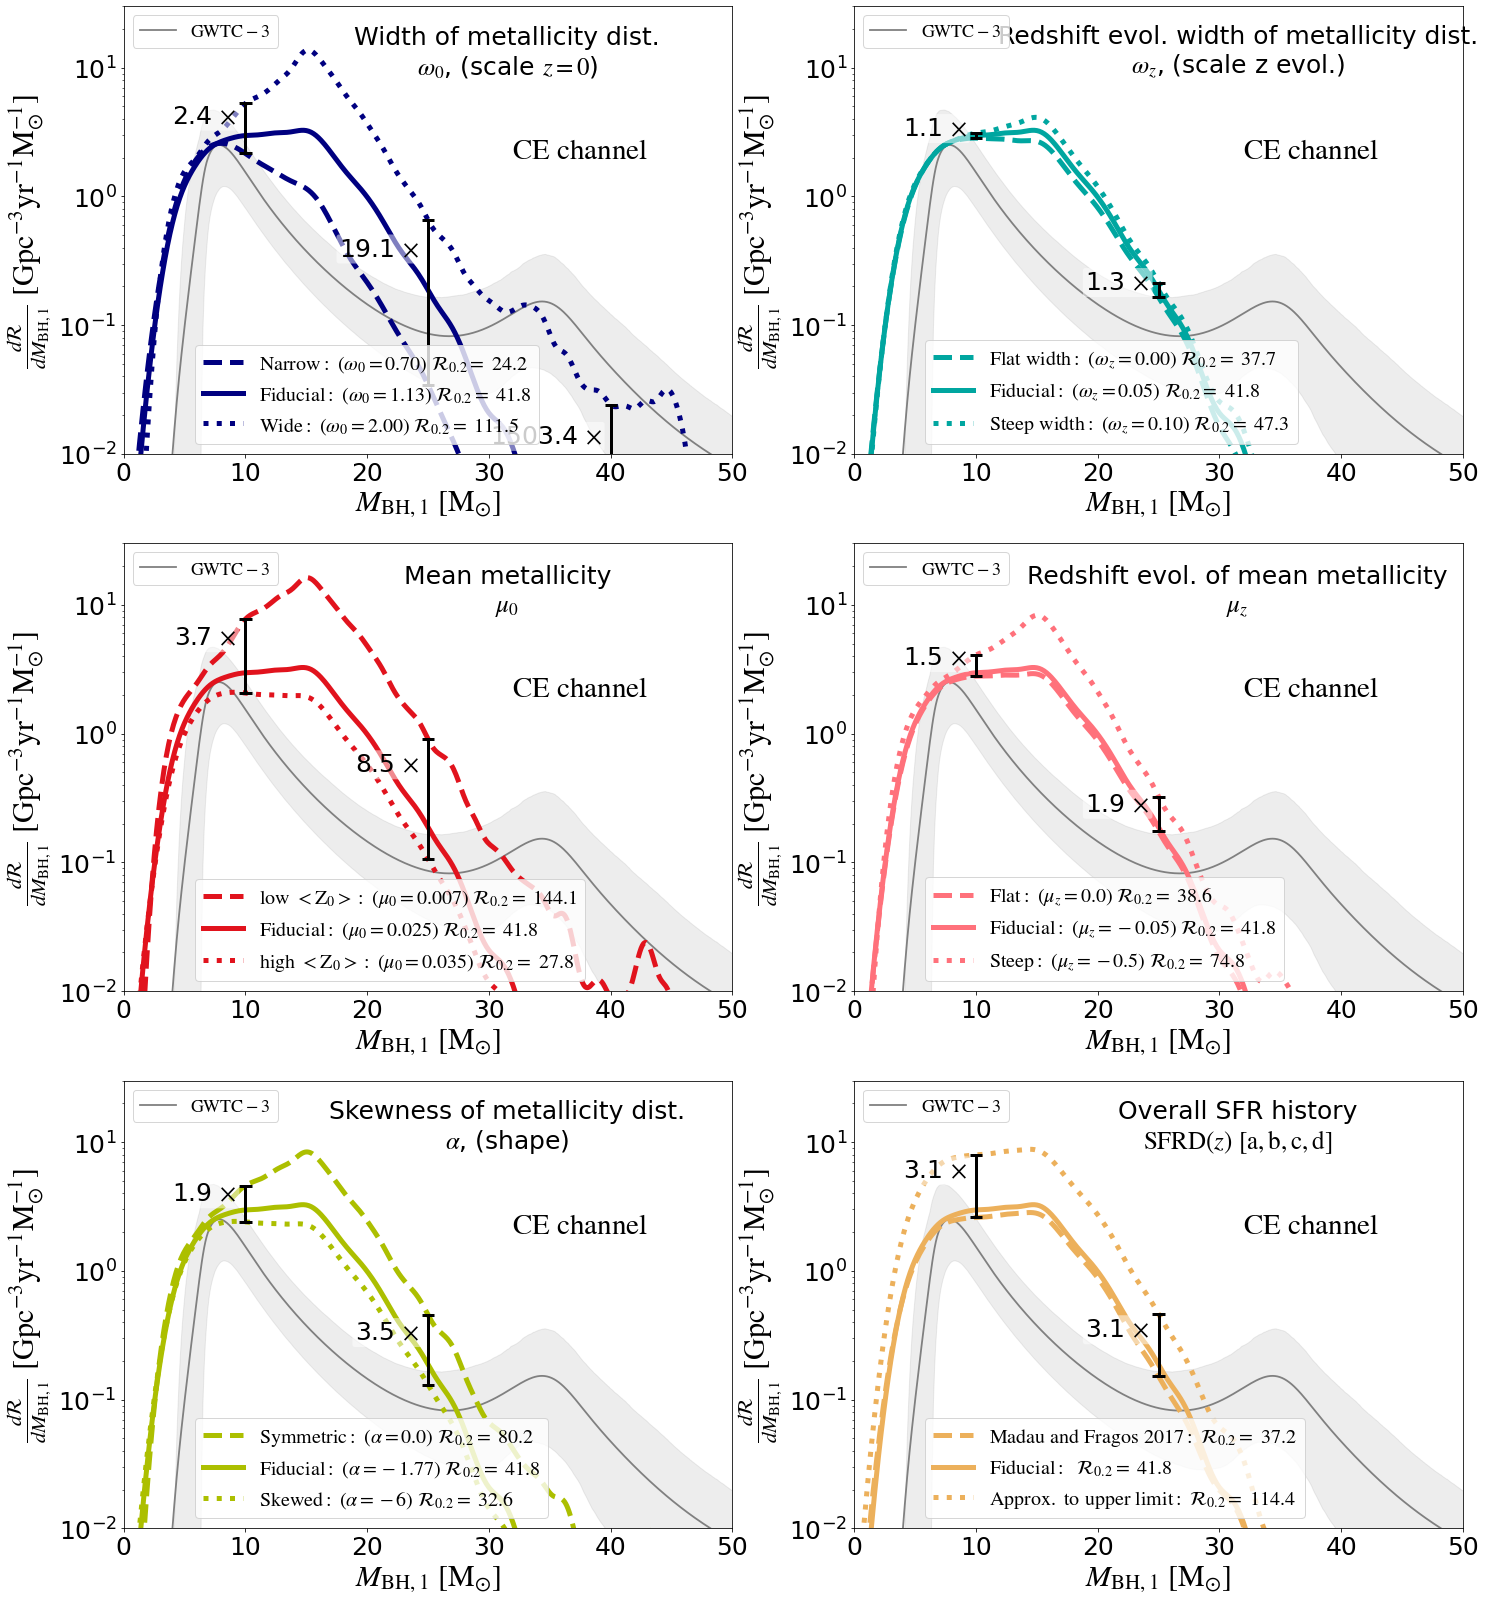

In [33]:
#plotting
fig = plt.figure( figsize = (24, 28))

# width of SFRD at z=0 - sigma0 varied
subplot1 = fig.add_subplot(321) #first subplot in layout that has 3 rows and 2 columns
ax1 = pltmass.plot_mass_distribution(sim_dir = data_dir, rate_file='/'+str(rate_file_name), simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys  = ['Rates_mu00.025_muz-0.049_alpha-1.79_sigma0%s_sigmaz0.048_a0.017_b1.487_c4.442_d5.886_zBinned'%(x) for x in [0.7, 1.129, 2.0]], channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color =  'navy',
                           only_CE = only_CE, only_stable = only_stable, 
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_width_variations.pdf', titletext = "Width of metallicity dist."+"\n"+r"$\omega_0$, (scale $z=0$)",
                           labels = [r'$\mathrm{Narrow: \ }  (\omega_0 = 0.70) \  \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \ } (\omega_0 = 1.13) \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Wide: \ } (\omega_0 = 2.00) \  \mathcal{R}_{0.2} = \ $'],
                          multipanel = True, subplot = subplot1)

# Redshift evolution of the width - sigma z varied
subplot2 = fig.add_subplot(322)
ax2 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz%s_a0.017_b1.487_c4.442_d5.886_zBinned'%(x) for x in [0.0, 0.048, 0.1]],channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#00a6a0', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_zevol_width_variations.pdf',  titletext = "Redshift evol. width of metallicity dist." +"\n"+ r"$\omega_z$, (scale z evol.)",
                           labels = [r'$\mathrm{Flat \ width: \ } (\omega_z = 0.00) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \ } (\omega_z = 0.05) \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Steep \ width: \ } (\omega_z = 0.10) \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot2)

# Mean metallicity at z=0 - mu0 varied
subplot3 = fig.add_subplot(323)
ax3 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu0%s_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048_a0.017_b1.487_c4.442_d5.886_zBinned'%(x) for x in [0.007, 0.025, 0.035]],channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#e1131d', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_meanZ_variations.pdf',  titletext = 'Mean metallicity'+"\n"+r"$\mu_0$",
                           labels = [r'$\mathrm{low \ <Z_0> : \ } (\mu_0 = 0.007) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial : \ }  (\mu_0 = 0.025) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{high \ <Z_0> : \ } (\mu_0 = 0.035) \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot3)

# Redshift evolution of mean metallicity - mu z varied
subplot4 = fig.add_subplot(324)
ax4 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu00.025_muz%s_alpha-1.79_sigma01.129_sigmaz0.048_a0.017_b1.487_c4.442_d5.886_zBinned'%(x) for x in [0.0, -0.049, -0.5]],channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#ff717b', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_zevol_mean_variations.pdf', titletext = "Redshift evol. of mean metallicity" +"\n"+ r"$\mu_z$", 
                           labels = [r'$\mathrm{Flat: \ }  (\mu_z = 0.0) \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \ } (\mu_z = -0.05) \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Steep: \ } (\mu_z = -0.5) \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot4)

# Skewness - alpha varied
subplot5 = fig.add_subplot(325)
ax5 = pltmass.plot_mass_distribution(sim_dir = data_dir,rate_file='/'+str(rate_file_name) , simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  rate_keys = ['Rates_mu00.025_muz-0.049_alpha%s_sigma01.129_sigmaz0.048_a0.017_b1.487_c4.442_d5.886_zBinned'%(x) for x in [0.0, -1.79, -6.0]],channel_string = channel_string,
                           show_hist = False, show_KDE = True, plot_LIGO = True, Color = '#acbf00', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_skewness_variations.pdf', titletext = "Skewness of metallicity dist." +"\n"+ r"$\alpha$, (shape)", 
                           labels = [r'$\mathrm{Symmetric: \ } (\alpha = 0.0)   \ \mathcal{R}_{0.2} = \ $',
                                     r'$\mathrm{Fiducial: \  } (\alpha = -1.77)  \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Skewed: \    } (\alpha = -6)  \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot5)

# Star formation norm - SFRD(z) varied
subplot6 = fig.add_subplot(326)
ax6 = pltmass.plot_mass_distribution(sim_dir = data_dir, rate_file='/'+str(rate_file_name), simulation_data = '/'+str(COMPASfilename),
                           x_key = 'M_moreMassive',  
                           rate_keys = ['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048_a0.01_b2.6_c3.2_d6.2_zBinned',
                                       'Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048_a0.017_b1.487_c4.442_d5.886_zBinned', 
                                       'Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048_a0.03_b2.6_c3.3_d5.9_zBinned'],
                                 channel_string = channel_string,
                           show_hist = False, show_KDE = True,  plot_LIGO = True, Color = '#ecb05b', 
                           only_CE = only_CE, only_stable = only_stable,
                           bootstrap = False, bootstraps = 50, save_name = 'SFRD_skewness_variations.pdf', titletext = "Overall SFR history"+"\n"+ r'$ \mathrm{SFRD(}z\rm{)} \ [a,b,c,d]$', 
                           labels = [r'$\mathrm{Madau \ and \ Fragos \ 2017: }  \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Fiducial: \ } \ \mathcal{R}_{0.2}= \ $', 
                                     r'$\mathrm{Approx. \ to \ upper \ limit:}  \ \mathcal{R}_{0.2} = \ $'],
                            multipanel = True, subplot = subplot6)

## Figure 5: Residuals of fitted model to TNG

In [34]:
import importlib
import ReadFitData as read
importlib.reload(read)
Cosmol_sim_location = data_dir + "/SFRMetallicityFromGasTNG100.hdf5"

In [35]:
#Read in TNG 100 data and fitted data
#Note this is reading in lookback times, and metallicity info, and SFRD(z)
#Again doesn't read in redshifts directly from file - keep an eye out for z_at_value in subsequent code
Sim_SFRD, Lookbacktimes, Sim_center_Zbin, step_fit_logZ, Redshifts = read.load_TNG100(loc = Cosmol_sim_location)
fit_filename = 'test_best_fit_parameters.txt'

In [36]:
"""
Now make some cuts because the minimum metallicity in COMPAS is 10^-4, no need to fit the 10^-7 metallicity tail. 
Cuts out the POP-III star formation. Since we don't capture this kind of stellar evolution in the pop-synth, we don't 
want to skew our distribution to try and capture that
"""
#adjust which metallicities to include
minZ_popSynth    =  1e-6
tofit_Sim_metals = Sim_center_Zbin[np.where(Sim_center_Zbin > minZ_popSynth)[0]]   

#Reverse time axis of the SFRD and lookback time for the fit
tofit_Sim_SFRD      = Sim_SFRD[:,np.where(Sim_center_Zbin > minZ_popSynth)[0]][::-1]
tofit_Sim_lookbackt = Lookbacktimes[::-1] 

# Convert lookback times to redshifts (!!!)
# the last value of Lookbacktimes = 0, which is problematic for z calculation
redshifts_Sim = [z_at_value(cosmo.lookback_time,t*u.Gyr,method='Bounded') for t in Lookbacktimes[:-1]] 
redshifts_Sim.append(0) # put redshift zero back at the end
redshifts_Sim = np.array(redshifts_Sim)

In [37]:
# Interpolate the fit data using scipy interpolate
f_interp = interpolate.interp2d(tofit_Sim_lookbackt, tofit_Sim_metals, tofit_Sim_SFRD.T, kind='cubic')

In [38]:
# Retrieve values at higher res regular intervals
redshift_new         = np.arange(0, 10.1, 0.05)
Lookbacktimes_new    = [cosmo.lookback_time(z).value for z in redshift_new] #here using consistent conversion since fit data

log_tofit_Sim_metals = np.log10(tofit_Sim_metals)
metals_new           = np.logspace(min(log_tofit_Sim_metals), max(log_tofit_Sim_metals), 100)

SFRDnew = f_interp(Lookbacktimes_new,metals_new)

In [39]:
def calc_chi_square(fit_metals, Redshifts = [],  simulation_SFRD = [],
                        mu_0  = 0.026, muz  =-0.09, sigma0  = 1.9, sigmaz  = 1.9, alpha =-3.3,
                        sf_a =0.01 , sf_b=2.6, sf_c=3.2 , sf_d=6.2):
    # Get the SFR (Shape of Madau & Fragos 2014)
    sfr = Z_SFRD.Madau_Dickinson2014(Redshifts, a=sf_a, b=sf_b, c=sf_c, d=sf_d).value
    # Get dPdZ (skew log normal distribution)
    dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(Redshifts,mu_z = muz , mu_0 = mu_0 ,
                                                      omega_0= sigma0 , omega_z=sigmaz , alpha = alpha , 
                                                      metals=fit_metals)
    data = simulation_SFRD
    model = sfr[:,np.newaxis] * dPdlogZ
    
    res_squared = ((data - model )**2) #residuals squared)
    chi_square = res_squared/np.sum(model, axis = 1)[:,np.newaxis] #divide over sum of model at each redshift
    return np.sum(chi_square), data, model

In [40]:
def test_chi(x0 = [-0.09, 0.026, 1.9, 0.1, -3.3, 0.01, 2.6, 3.2, 6.2] ):
        chi_square, data, model = calc_chi_square(metals_new, Redshifts = redshift_new, simulation_SFRD = SFRDnew.T, 
                                           muz  =x0[0], mu_0  =x0[1],sigma0  =x0[2], sigmaz =x0[3], alpha  =x0[4],
                                           sf_a =x0[5], sf_b=x0[6], sf_c=x0[7], sf_d=x0[8])
        return chi_square

In [41]:
# BEST GUESS - note this uses the fitted redshifts, not ones from TNG
x0 = np.array([-0.15, 0.026, 1.1, 0.1, -3.3, 0.01, 2.6, 3.2, 6.2])

bounds = ((-1., 0), (0.001, 0.1), (0.01, 5), (0, 1.), (-10, 0), (None,None),(None,None),(None,None),(None,None))

# FIT - use scipy minimize to get best fit
res = minimize(test_chi, x0= x0, method = 'BFGS',# other options include: 'nelder-mead', L-BFGS-B
                   options = {'gtol': 0.05})#{'maxiter': 5000})

print(res.success, res.message, 'N iterations: ', res.nit)
muz_best, mu0_best, sigma0_best, sigmaz_best, alpha_best = res.x[0], res.x[1], res.x[2], res.x[3],res.x[4]
sf_a_best, sf_b_best, sf_c_best, sf_d_best = res.x[5], res.x[6], res.x[7], res.x[8] 

print('\nBEST FITTING PARAMETERS:')
print('mu0 =%s, muz =%s, sigma_0 =%s, sigma_z =%s, alpha=%s'% (mu0_best, muz_best, sigma0_best, sigmaz_best, alpha_best) )
print('sf_a =%s, sf_b =%s, sf_c =%s, sf_d =%s'% (sf_a_best, sf_b_best, sf_c_best, sf_d_best) )

True Optimization terminated successfully. N iterations:  30

BEST FITTING PARAMETERS:
mu0 =0.02448920602373161, muz =-0.05222710365245152, sigma_0 =1.1725895324672535, sigma_z =0.048956798300943585, alpha=-2.04822748293321
sf_a =0.017426381634921523, sf_b =1.4332174997122133, sf_c =4.529649262333126, sf_d =6.043506913820477


In [42]:
chi_square, data, model  = calc_chi_square(metals_new, Redshifts = redshift_new, simulation_SFRD = SFRDnew.T, 
                                       muz =muz_best, mu_0 =mu0_best,sigma0 =sigma0_best, sigmaz=sigmaz_best,alpha=alpha_best,
                                       sf_a =sf_a_best, sf_b=sf_b_best, sf_c=sf_c_best, sf_d=sf_d_best)
res_squared = ((data - model )**2)
print('chi_square',chi_square, 'max res_squared', np.amax(res_squared) )

chi_square 0.03730294092101196 max res_squared 5.1099001347042486e-05


In [43]:
# Calculate standard error on params
from numpy.linalg import inv
N_elements  = len(data.flatten()) 
v = res['fun']/   N_elements  # variance of residuals, sse/n
var = v*inv(res['hess_inv'])
se = np.sqrt(np.diag(var))
print('standard error', se)

standard error [0.01216623 0.07348552 0.00227301 0.02318894 0.00074203 0.14765196
 0.00370665 0.00197801 0.00061942]


In [44]:
# plotting the squared residuals because that is what is used to optimize
# PLOT setttings
from matplotlib import rc
import matplotlib
from matplotlib import ticker, cm
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('font', family='serif')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
Zsun = 0.014 # Solar metallicity

[-7. -6. -5. -4. -3. -2.]


(-3.0, 1.5)

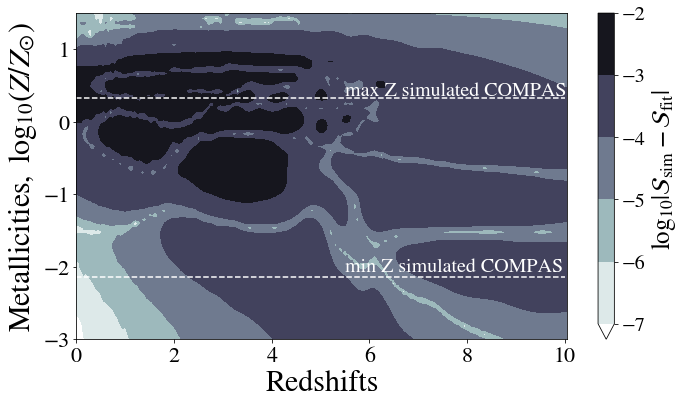

In [45]:
fig, ax = plt.subplots(figsize = (11,6))
X,Y = np.meshgrid(redshift_new,  np.log10(metals_new/Zsun))
levs = np.linspace(-7, -2, num=6)
print(levs)
cs = plt.contourf(X, Y, np.log10(abs(data-model).T), 
                      levs, cmap ="bone_r",extend ='min')

cbar = plt.colorbar(cs)
cbar.ax.set_ylabel(r'$\log_{10} | \mathcal{S}_{\rm sim} -\mathcal{S}_{\rm fit}| $ ',
                       fontsize = 25)
cbar.ax.tick_params(labelsize=20)

# Min and max simulated metallicities in COMPAS
ax.annotate('min Z simulated COMPAS', (5.5, np.log10(1.2e-4/Zsun)), fontsize = 20, color = 'white' )
plt.hlines(np.log10(1e-4/Zsun), xmin = 0, xmax = 10, color = 'white', linestyle = '--')
ax.annotate('max Z simulated COMPAS', (5.5, np.log10(0.032/Zsun)), fontsize = 20, color = 'white' )
plt.hlines(np.log10(0.03/Zsun), xmin = 0, xmax = 10, color = 'white', linestyle = '--')

# Plot values
ax.set_xlabel('Redshifts', fontsize = 30)
ax.set_ylabel('$\mathrm{Metallicities}, \ \log_{10}(Z/Z_{\odot})$', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=22)
plt.ylim(-3,1.5)

[-3. -2. -1.  0.  1.  2.  3.]


(-3.0, 1.5)

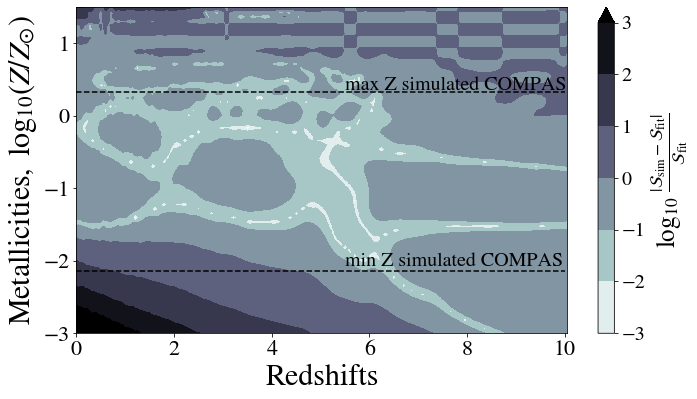

In [46]:
abs_relative_err = abs(data-model)/model

fig, ax = plt.subplots(figsize = (11,6))
X,Y = np.meshgrid(redshift_new,  np.log10(metals_new/Zsun))
levs = np.linspace(-3, 3, num=7)
print(levs)
cs = plt.contourf(X, Y, np.log10(abs_relative_err).T, 
                      levs, cmap ="bone_r",extend ='max')

cbar = plt.colorbar(cs)
cbar.ax.set_ylabel(r'$\log_{10} \ \frac{| \mathcal{S}_{\rm sim} - \mathcal{S}_{\rm fit} | }{\mathcal{S}_{\rm fit}} $ ',
                       fontsize = 25)
cbar.ax.tick_params(labelsize=20)

# Min and max simulated metallicities in COMPAS
ax.annotate('min Z simulated COMPAS', (5.5, np.log10(1.2e-4/Zsun)), fontsize = 20, color = 'black' )
plt.hlines(np.log10(1e-4/Zsun), xmin = 0, xmax = 10, color = 'black', linestyle = '--')
ax.annotate('max Z simulated COMPAS', (5.5, np.log10(0.032/Zsun)), fontsize = 20, color = 'black' )
plt.hlines(np.log10(0.03/Zsun), xmin = 0, xmax = 10, color = 'black', linestyle = '--')

# Plot values
ax.set_xlabel('Redshifts', fontsize = 30)
ax.set_ylabel('$\mathrm{Metallicities}, \ \log_{10}(Z/Z_{\odot})$', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=22)
plt.ylim(-3,1.5)

## Figure 6: checking SFRD(Z,z) fit makes sense

In [47]:
from pylab import *

##PLOT setttings
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('font', family='serif')
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,20,20,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

In [48]:
SOLAR_METALLICITY = 0.0127
fig_data_dir = data_dir +'/Figure5/' 
TNG = 50
lvl = 1

In [49]:
#Define functions for getting mass metallicity data from simulations that are used:

In [50]:
def getStellarMassMetallicityTNG():
    fout = fig_data_dir + "StellarMassMetallicityTNG%d-%d.hdf5" % (TNG,lvl)
    if os.path.exists( fout ):
        return
  
    print( "Computing data TNG%d" % TNG )

    snap = 99
    s    = gadget_readsnap( snap, snappath=TNGpath, snapbase='snap_', loadonlytype=[5], loadonly=['mass'], chunk=0 )
    Mass = np.zeros( (nBinsRedshift,nBinsMetallicity) )

    fname = "%s/snapdir_%03d/snap_%03d.%s.hdf5" % (TNGpath, snap, snap, "%d")
    for ifile in range( s.num_files ):
        with h5py.File(fname % ifile, "r") as f:
            print( "Reading file %d/%d." % (ifile,s.num_files) )

            pStars = f["PartType4"]

            Ages   = pStars["GFM_StellarFormationTime"][:]
            Masses = pStars["GFM_InitialMass"][:].astype('f8')
            Metals = pStars["GFM_Metallicity"][:] / SOLAR_METALLICITY # convert to solar metallicity

        for ir in range(nBinsRedshift):
            i, = np.where( Ages >= 1./(1.+redshifts[ir]) )

            Mass[ir,0] += Masses[i].sum()

            k, = np.where( Metals[i] < 0.1 )
            Mass[ir,1] += Masses[i[k]].sum()

            k, = np.where( Metals[i] > 1.0 )
            Mass[ir,2] += Masses[i[k]].sum()      

    with h5py.File(fout, "w") as f:
        f.create_dataset('BinsRedshift', data=redshifts )
        f.create_dataset('Mass', data=Mass )

In [51]:
def getStellarMassMetallicityIllustris():
    fout = fig_data_dir + "StellarMassMetallicityIllustris.hdf5" 
    if os.path.exists( fout ):
        return

    print( "Computing data Illustris" )

    snap = 135
    s    = gadget_readsnap( snap, snappath=IllustrisPath + "Illustris-1/output/", snapbase='snap_', loadonlytype=[5], loadonly=['mass'], chunk=0 )
    Mass = np.zeros( (nBinsRedshift,nBinsMetallicity) )

    fname = "%s/Illustris-1/output/snapdir_%03d/snap_%03d.%s.hdf5" % (IllustrisPath, snap, snap, "%d")
    for ifile in range( s.num_files ):
        with h5py.File(fname % ifile, "r") as f:
            print( "Reading file %d/%d." % (ifile,s.num_files) )

            pStars = f["PartType4"]

            Ages   = pStars["GFM_StellarFormationTime"][:]
            Masses = pStars["GFM_InitialMass"][:].astype('f8')
            Metals = pStars["GFM_Metallicity"][:] / SOLAR_METALLICITY # convert to solar metallicity

            for ir in range(nBinsRedshift):
                i, = np.where( Ages >= 1./(1.+redshifts[ir]) )

                Mass[ir,0] += Masses[i].sum()

                k, = np.where( Metals[i] < 0.1 )
                Mass[ir,1] += Masses[i[k]].sum()

                k, = np.where( Metals[i] > 1.0 )
                Mass[ir,2] += Masses[i[k]].sum() 

  
    with h5py.File(fout, "w") as f:
        f.create_dataset('BinsRedshift', data=redshifts )
        f.create_dataset('Mass', data=Mass )

In [52]:
def getStellarMassMetallicitySimba():
    fout = fig_data_dir + "StellarMassMetallicitySimba.hdf5" 
    if os.path.exists( fout ):
        return

    print( "Computing data Simba" )

    Mass = np.zeros( (nBinsRedshift,nBinsMetallicity) )

    snap  = 151
    fname = "%s/Simba-L100n1000FP/output/snapdir_%03d/snap_%03d.0.hdf5" % (IllustrisPath, snap, snap)
    with h5py.File(fname, "r") as f:
        pStars = f["PartType4"]

    Ages   = pStars["StellarFormationTime"][:]
    Masses = pStars["Masses"][:].astype('f8')
    Metals = pStars["Metallicity"][:][:,2:].sum(axis=1) / SOLAR_METALLICITY # convert to solar metallicity

    for ir in range(nBinsRedshift):
        i, = np.where( Ages >= 1./(1.+redshifts[ir]) )

        Mass[ir,0] += Masses[i].sum()

        k, = np.where( Metals[i] < 0.1 )
        Mass[ir,1] += Masses[i[k]].sum()

        k, = np.where( Metals[i] > 1.0 )
        Mass[ir,2] += Masses[i[k]].sum()      
  
    with h5py.File(fout, "w") as f:
        f.create_dataset('BinsRedshift', data=redshifts )
        f.create_dataset('Mass', data=Mass )

In [53]:
def getStellarMassMetallicityEagle():
    fout = fig_data_dir + "StellarMassMetallicityEagle.hdf5" 
    if os.path.exists( fout ):
        return

    print( "Computing data Eagle" )

    snap = 28
    s    = gadget_readsnap( snap, snappath=IllustrisPath + "Eagle-L68n1504FP/output/", snapbase='snap_', loadonlytype=[5], loadonly=['mass'], chunk=0 )
    Mass = np.zeros( (nBinsRedshift,nBinsMetallicity) )

    fname = "%s/Eagle-L68n1504FP/output/snapdir_%03d/snap_%03d.%s.hdf5" % (IllustrisPath, snap, snap, "%d")
    for ifile in range( s.num_files ):
        with h5py.File(fname % ifile, "r") as f:
            print( "Reading file %d/%d." % (ifile,s.num_files) )

            pStars = f["PartType4"]

            Ages   = pStars["GFM_StellarFormationTime"][:]
            Masses = pStars["GFM_InitialMass"][:].astype('f8')
            Metals = pStars["GFM_Metallicity"][:] / SOLAR_METALLICITY # convert to solar metallicity

            for ir in range(nBinsRedshift):
                i, = np.where( Ages >= 1./(1.+redshifts[ir]) )

                Mass[ir,0] += Masses[i].sum()

                k, = np.where( Metals[i] < 0.1 )
                Mass[ir,1] += Masses[i[k]].sum()

                k, = np.where( Metals[i] > 1.0 )
                Mass[ir,2] += Masses[i[k]].sum()      

    with h5py.File(fout, "w") as f:
        f.create_dataset('BinsRedshift', data=redshifts )
        f.create_dataset('Mass', data=Mass )

In [54]:
#Read data from Matryna
def read_Chruslinskadata():

    # Name of the low and high Z extreme
    low_Z_file =  '214'+ 'f14SB'+'BiC'+ '_FMR270'  #+ '_FOH_z_dM.dat'
    Low_Z_extreme  = [] # will be filled with [Z10, Z01] for the 3 redshifts
    high_Z_file = '302'+ 'f14SB'+'Boco'+ '_FMR270' #+ '_FOH_z_dM.dat'
    High_Z_extreme = [] # will be filled with [Z10, Z01] for the 3 redshifts

    dataChruslinska19_Z01 = [[],[],[]]
    dataChruslinska19_Z10 = [[],[],[]]

    dataChruslinska21_Z01 = [[],[],[]]
    dataChruslinska21_Z10 = [[],[],[]]

    for iz in range(3):
        z = ["10.0", "3", "0.5"][iz]
        print('\n z=',z)
        with open( fig_data_dir + "/stellar_mass_fractions_Zsun_Asplund09_zmax_%s.dat" % z, "r" ) as f:
            lines = f.readlines()
            
        for line in lines[1:]:
            Z01 = float(line.split()[2])
            Z10 = float(line.split()[3])

            # check if model_id == low or high Z file
            if str(line.split()[1]) == low_Z_file:
                print('found low Z extreme: ', line.split()[1] )
                print(Z10, Z01)
                Low_Z_extreme.append([Z10, Z01])
                
            if str(line.split()[1]) == high_Z_file:
                print('found high Z extreme: ', line.split()[1] )
                print(Z10, Z01)
                High_Z_extreme.append([Z10, Z01])
            
            if line.startswith( "ChN19" ):
                dataChruslinska19_Z01[iz] += [Z01]
                dataChruslinska19_Z10[iz] += [Z10]
            else:
                dataChruslinska21_Z01[iz] += [Z01]
                dataChruslinska21_Z10[iz] += [Z10]

    return Low_Z_extreme, High_Z_extreme, dataChruslinska19_Z01, dataChruslinska19_Z10, dataChruslinska21_Z01, dataChruslinska21_Z10

In [55]:
#SFRD(Z, z) for model
def get_SFRDzZ(redshifts, metals = [], min_logZ_COMPAS = np.log(1e-4), max_logZ_COMPAS = np.log(0.03),
               metal_params = [], SFR_Params = [], min_logZ=-12.0, max_logZ=0.0, step_logZ =0.01): 

    mu_0, mu_z, omega_0, omega_z, alpha = metal_params
    a, b, c, d                          = SFR_Params
    # metallicity distribution
    dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                    Z_SFRD.skew_metallicity_distribution(redshifts, mu_0=mu_0, mu_z=mu_z,alpha = alpha, 
                                                  omega_0=omega_0, omega_z =omega_z, min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                                  metals = metals ) 
    # SFR
    sfr        = Z_SFRD.Madau_Dickinson2014(redshifts, a=a, b=b, c=c,  d=d) # Msun year-1 Mpc-3 
    # Combine it into a SFRD
    model_SFRD = (sfr*(dPdlogZ*step_logZ  ).T ).value #step_logZ
    
    return model_SFRD, metallicities, step_logZ

In [56]:
getStellarMassMetallicityTNG()
getStellarMassMetallicityIllustris()
getStellarMassMetallicitySimba()
getStellarMassMetallicityEagle()

Computing data TNG50


NameError: name 'gadget_readsnap' is not defined

In [ ]:
#Get redshifts and masses from simulations

with h5.File(fig_data_dir + "StellarMassMetallicityTNG%d-%d.hdf5" % (TNG,lvl), "r") as f:
        TNGBinsRedshift = f["BinsRedshift"][:]
        TNGMass         = f["Mass"][:]

with h5.File(fig_data_dir + "StellarMassMetallicityIllustris.hdf5", "r") as f:
        IllustrisBinsRedshift = f["BinsRedshift"][:]
        IllustrisMass         = f["Mass"][:]

with h5.File(fig_data_dir + "StellarMassMetallicitySimba.hdf5", "r") as f:
        SimbaBinsRedshift = f["BinsRedshift"][:]
        SimbaMass         = f["Mass"][:]

with h5.File(fig_data_dir + "StellarMassMetallicityEagle.hdf5", "r") as f:
        EagleBinsRedshift = f["BinsRedshift"][:]
        EagleMass         = f["Mass"][:]

In [ ]:
# Observational constraints from Chruslinska 2021
Low_Z_extreme, High_Z_extreme, dataChruslinska19_Z01, dataChruslinska19_Z10, dataChruslinska21_Z01, dataChruslinska21_Z10 = read_Chruslinskadata()

In [ ]:
# Load TNG 100 data (redshifts!!!!!)
with h5.File(data_dir + "/SFRMetallicityFromGasTNG100.hdf5", "r") as file:
        MetalBins            = file["MetalBins"][:] #60
        TNG100_center_Zbin   = (MetalBins[:-1] + MetalBins[1:])/2.
        TNG100_Lookbacktimes = file["Lookbacktimes"][:] #100
        BoxSfr               = file["Sfr"][:]
        TNG100_Redshifts     = file["Redshifts"][:] #100
# Convert SFR from sfr/box to sfr cMpc-3
littleh    = 0.6774
Rbox       = 75/littleh
TNG100_SFR = BoxSfr / Rbox**3 *u.Mpc**-3

# The model comes in SFRD/DeltaZ, make sure your data does as well!! 
step_fit_logZ       = np.diff(np.log(MetalBins))[0]    
TNG100_cosmic_SFR   = TNG100_SFR#/step_fit_logZ

# Convert lookback times to redshifts (!!!!!!!)
# the last value of Lookbacktimes = 0, which is problematic for z calculation
Redshifts_TNG100 = [z_at_value(cosmo.lookback_time,t*u.Gyr,method='Bounded') for t in TNG100_Lookbacktimes[:-1]] 
Redshifts_TNG100.append(0) # put redshift zero back at the end
Redshifts_TNG100 = np.array(Redshifts_TNG100)

In [ ]:
#Interpolate data --> calculates redshifts here rather than using the TNG100 redshifts - may avoid issues
interpolate_data = True
if interpolate_data:
        #########################################
        # Interpolate the simulation data
        f_interp = interpolate.interp2d(TNG100_Lookbacktimes, TNG100_center_Zbin, TNG100_cosmic_SFR.T, kind='cubic')

        redshift_new         = np.arange(0, 10.1, 0.05)         # Retrieve values at higher res regular intervals
        Lookbacktimes_new    = [cosmo.lookback_time(z).value for z in redshift_new]

        log_TNG100_center_Zbin = np.log10(TNG100_center_Zbin)
        metals_new             = np.logspace(min(log_TNG100_center_Zbin), max(log_TNG100_center_Zbin), int(1e3))

        SFRDnew = f_interp(Lookbacktimes_new,metals_new)

        SFRDnew = SFRDnew.T
        # Original TNG data was in decreasing t_lookback, so reshape your new interpolated thing the same way
        SFRDnew           = SFRDnew[::-1]
        redshift_new      = redshift_new[::-1]
        Lookbacktimes_new = np.array(Lookbacktimes_new[::-1])
        #########################################
        print(50*'*', '\nYou are using the interpolated version')
        # # switch to new interpolated data
        TNG100_cosmic_SFR    = SFRDnew
        TNG100_Lookbacktimes = Lookbacktimes_new
        MetalBins            = metals_new
        TNG100_center_Zbin   = metals_new#(metals_new[:-1] + metals_new[1:])/2.
        TNG100_redshifts     = redshift_new

In [ ]:
# We are going to convert SFR to total stellar mass formed
TNG100_centered_SFR       = (TNG100_cosmic_SFR[:-1,:] + TNG100_cosmic_SFR[1:,:])/2.          # Take the SFRD at the center of each bin in lookback time    
TNG100_Lookbacktimes_yr   = TNG100_Lookbacktimes *u.Gyr.to(u.yr)                             # Multiply this by the diff in lookback time to get the total stellar mass formed in each lookback time bin
TNG100_stellarM_formed_dZ = (TNG100_centered_SFR * abs(np.diff(TNG100_Lookbacktimes_yr))[:,np.newaxis])  # This gives us the stellar mass formed at t, per Mpc^-3 per d logZ (it's still 2D)
TNG100_center_redshifts   = (TNG100_redshifts[:-1] + TNG100_redshifts[1:])/2.                 # Take the center of the redshift bins to match the shape of TNG100_stellarM_formed_dZ